In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import json
import os

from scipy.optimize import minimize
from scipy import constants
from scipy.spatial import distance_matrix

k_b = constants.physical_constants['Boltzmann constant in eV/K'][0]

from pymatgen.core.structure import Structure, Molecule
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer, PointGroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor

from ase.visualize import view

from utils import *
from random_structures import *
from QUBO_models import *

from braket.ahs.atom_arrangement import AtomArrangement, SiteType
from braket.ahs.driving_field import DrivingField
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation


def vview(structure):
    view(AseAtomsAdaptor().get_atoms(structure))

eV_to_rad_s = 1.519267447321156e15



## Parameters

In [2]:
C6 = 5.42e-24
reg_coef = [0.0003613877583255407, 0.00020311860082042723]
reg_coef_rad_s  = np.array(reg_coef)*eV_to_rad_s

V_max = (C6/(4.01e-6**6))
V_dft = reg_coef[1]*eV_to_rad_s
alpha_v = V_dft/V_max

alpha_v

236.72868078912074

## Small structure (4x3)

### Exhaustive search

Stacked

In [3]:
for i,j in enumerate(-np.linspace(125000000, -62500000, 10)):
    print(i,j)

0 -125000000.0
1 -104166666.66666667
2 -83333333.33333334
3 -62500000.0
4 -41666666.66666667
5 -20833333.333333343
6 -0.0
7 20833333.333333313
8 41666666.66666666
9 62500000.0


### Fit temperature

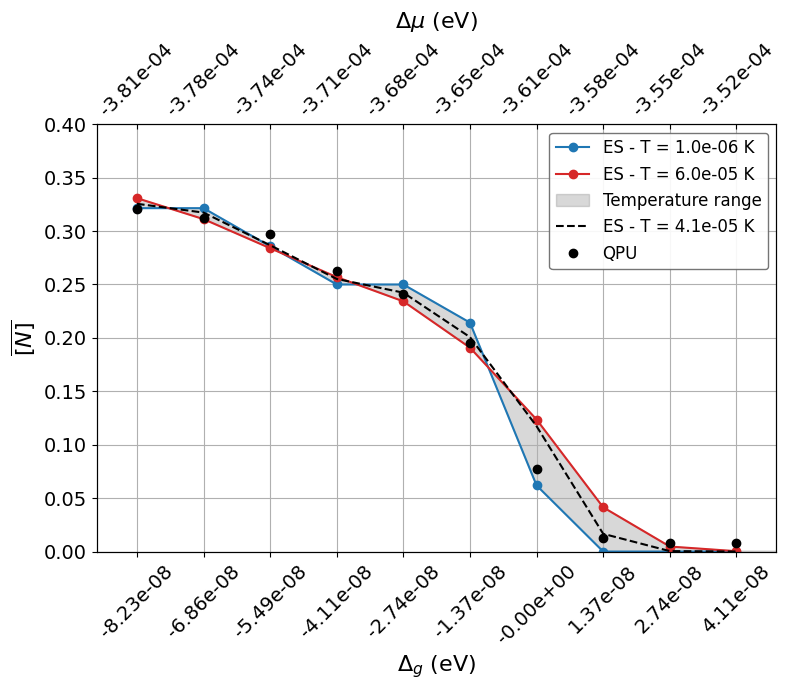

In [4]:
# === Setup plot ===
fig, ax = plt.subplots(figsize=(8, 7))

# === Load and plot Boltzmann data ===
with open("data/exhaustive_search/production/av_conc_4x3_4um_all_T_hardware_values.json", "r") as f:
    boltzmann_data = json.load(f)

results_dict = {}
for T, Delta_mu, av_conc in boltzmann_data:
    T_str = f"{T:.6e}"
    if T_str not in results_dict:
        results_dict[T_str] = {"Delta_mu": [], "avg_conc": []}
    results_dict[T_str]["Delta_mu"].append(Delta_mu)
    results_dict[T_str]["avg_conc"].append(av_conc)

# for T_str, values in results_dict.items():
#     T = float(T_str)
#     if T < 100:
#         delta_mu = np.array(values["Delta_mu"])  # Already in eV
#         avg_conc = np.array(values["avg_conc"])
#         ax.plot(delta_mu, avg_conc, 'x', label=f'T={T:.1e}')

# Find min and max temperature entries
T_all = np.array([float(T_str) for T_str in results_dict.keys()])
T_all = T_all[0:60]
T_min = np.min(T_all)
T_max = np.max(T_all)

# Get corresponding data
delta_mu_min = np.array(results_dict[f"{T_min:.6e}"]["Delta_mu"])
avg_conc_min = np.array(results_dict[f"{T_min:.6e}"]["avg_conc"])

delta_mu_max = np.array(results_dict[f"{T_max:.6e}"]["Delta_mu"])
avg_conc_max = np.array(results_dict[f"{T_max:.6e}"]["avg_conc"])

# Sort both by delta_mu (for proper filling)
sort_min = np.argsort(delta_mu_min)
sort_max = np.argsort(delta_mu_max)

delta_mu_min = delta_mu_min[sort_min]
avg_conc_min = avg_conc_min[sort_min]

delta_mu_max = delta_mu_max[sort_max]
avg_conc_max = avg_conc_max[sort_max]

# Plot min T
ax.plot(delta_mu_min[:-1], avg_conc_min[:-1], 'o-', label=f"ES - T = {T_min:.1e} K", color='tab:blue')

# Plot max T
ax.plot(delta_mu_max[:-1], avg_conc_max[:-1], 'o-', label=f"ES - T = {T_max:.1e} K", color='tab:red')

# Fill between curves
ax.fill_between(delta_mu_min, avg_conc_min, avg_conc_max, color='gray', alpha=0.3, label='Temperature range')

# === Load hardware data ===
folder = 'qpu_data/production/3x4/4micron'
delta_g_all_int_neg = -np.linspace(125000000, -62500000, 10)
delta_g_all_int_neg_ticks = -np.linspace(125000000, -62500000, 10)/eV_to_rad_s
datasets = []
delta_mu_vals = []

for delta_g_idx in np.arange(10):
    path = os.path.join(folder, str(delta_g_idx))
    preseqs, postseqs = read_all_sequences_from_folder(path)
    preseqs = stack_chunks_vertically(np.array(preseqs))
    postseqs = stack_chunks_vertically(np.array(postseqs))
    datasets.append((preseqs, postseqs, f"Δg = {delta_g_idx}"))

    # Convert Δg to Δμ (eV)
    delta_g = -extract_detuning_values(path)[-1]
    # delta_mu = (-reg_coef_rad_s[0] + delta_g * alpha_v) / eV_to_rad_s
    # delta_mu_vals.append(delta_mu)

# === Compute Hamming distances and plot ===
hamming_average_all = []
hamming_average_std = []

for i, (preseqs, postseqs, label) in enumerate(datasets):
    len_hamming, hamming_avg, hamming_std, *_ = get_hamming(preseqs, postseqs)
    hamming_average_all.append(hamming_avg)
    hamming_average_std.append(hamming_std)

    preseqs = np.array(preseqs)
    postseqs = np.array(postseqs)
    num_atoms = preseqs.shape[1]
    keep_config = np.where(np.sum(preseqs, axis=1) == num_atoms)[0]

    hamming_all_tmp = np.sum(postseqs[keep_config] == 0, axis=1)
    hamming_unique, hamming_count = np.unique(hamming_all_tmp, return_counts=True)
    max_count = np.max(hamming_count)
    # x = [delta_mu_vals[i]] * len(hamming_count)

    # for j, hu in enumerate(hamming_unique):
    #     ax.plot(x[j], hu / 28, 'o', color='black', alpha=hamming_count[j] / max_count)

with open("data/exhaustive_search/production/av_conc_4x3_4um_production_T_4.1.json", "r") as f:
    boltzmann_data = json.load(f)

results_dict = {}
for T, Delta_mu, av_conc in boltzmann_data:
    T_str = f"{T:.6e}"  # stringify to match how it might be serialized in JSON
    if T_str not in results_dict:
        results_dict[T_str] = {
            "Delta_mu": [],
            "avg_conc": []
        }
    results_dict[T_str]["Delta_mu"].append(Delta_mu)
    results_dict[T_str]["avg_conc"].append(av_conc)

for T_str, values in results_dict.items():
    T = float(T_str)
    if T < 100:
        delta_mu = np.array(values["Delta_mu"]) 
        avg_conc = np.array(values["avg_conc"])
        ax.plot(delta_mu, avg_conc, '--', label=f'ES - T = {T:.1e} K',color='k')

# === Plot averaged Hamming data ===
x_vals = np.array(delta_g_all_int_neg/eV_to_rad_s)
y_vals = np.array(hamming_average_all) / 28
hamming_average_std = np.array(hamming_average_std) / 28
ax.plot(
    x_vals, y_vals,
    'o', 
    label='QPU', color='k'
)

# === Labels and formatting ===
ax.set_xlabel(r"$\Delta_g$ (eV)", fontsize=16)
ax.set_ylabel(r"$\overline{[N]}$", fontsize=16)
ax.set_ylim([0, 0.4])
ax.set_xlim([delta_g_all_int_neg_ticks[0]+delta_g_all_int_neg_ticks[0]*0.1, delta_g_all_int_neg_ticks[-1]-delta_g_all_int_neg_ticks[0]*0.1])

ax.set_xticks(delta_g_all_int_neg_ticks)
ax.set_xticklabels([f"{tick:.2e}" for tick in delta_g_all_int_neg_ticks],rotation=45)
ax.tick_params(labelsize=14)
# # === Add top x-axis ===
# ax_top = ax.twiny()  # create a twin of the original x-axis
# ax_top.set_xlim(ax.get_xlim())  # match limits with the bottom axis

# # Example: label in Δg (Hz) corresponding to your Δμ ticks

delta_g_hardware_ticks = delta_g_all_int_neg_ticks*alpha_v-reg_coef[0]#*alpha_v
# ax_top.set_xticks(delta_g_all_int_neg_ticks)  # use same positions as bottom axis
# ax_top.set_xticklabels([f"{val:.3e}" for val in delta_g_hardware_ticks], rotation=45)  # MHz scale

# ax_top.set_xlabel(r"$\Delta\mu$ (eV)", fontsize=16, labelpad=8)

# === Add top x-axis ===
ax_top = ax.twiny()
ax_top.set_xlim(ax.get_xlim())

# keep ticks but hide their labels
ax_top.set_xticks(delta_g_all_int_neg_ticks)
ax_top.set_xticklabels([f"{val:.2e}" for val in delta_g_hardware_ticks], rotation=45)

# label for the top axis
ax_top.set_xlabel(r"$\Delta\mu$ (eV)", fontsize=16, labelpad=8)

# cosmetic
ax_top.tick_params(direction='in', top=True, labelsize=14)
ax_top.grid(False)

ax.grid(True)
plt.tight_layout()
# ax_top.text(
#     0.0, 1.17,
#     rf"{-reg_coef[0]:.3e} eV",
#     transform=ax_top.transAxes,
#     ha="left",
#     va="bottom",
#     fontsize=12,
# )
# Add legend here
ax.legend(
    loc='best',
    fontsize=12,
    frameon=True,          # show the legend box
    facecolor='white',     # white background for clarity
    edgecolor='0.4',       # subtle grey border
    framealpha=0.9,        # slightly transparent
)
plt.show()

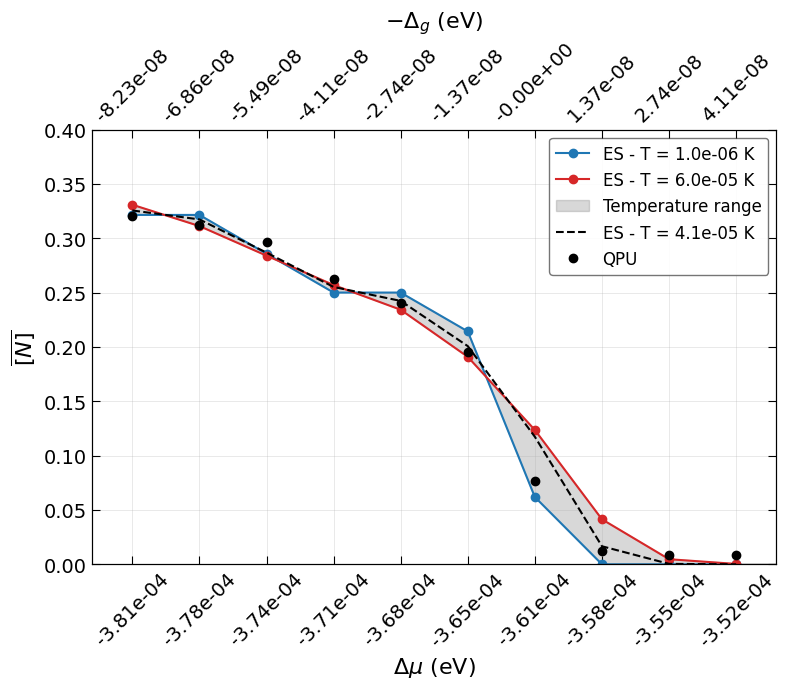

In [5]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# helper: load QPU results and compute (x_vals, y_vals, y_err)
# -------------------------------------------------------------------
def load_qpu_hamming_vs_detuning_for_plot(
    qpu_folder,
    detuning_indices,
    eV_to_rad_s,
    alpha_v,
    reg_coef,
):
    """
    Returns:
        x_vals              : np.array of bottom-axis x positions (Δg / eV_to_rad_s)
        y_mean              : np.array of avg concentration per detuning
        y_err               : np.array of std per detuning (here just std/num_atoms)
        delta_g_hw_list     : np.array of raw hardware detunings Δg (rad/s)
        delta_mu_ticks_eV   : np.array of corresponding Δμ (eV) using calibration
    """

    delta_g_hw_list = []
    y_mean_list = []
    y_std_list = []
    num_atoms_list = []

    for det_idx in detuning_indices:
        path = os.path.join(qpu_folder, str(det_idx))

        # load raw sequences
        preseqs, postseqs = read_all_sequences_from_folder(path)

        # if your version returns chunk lists, stack; if already flat 2D, this is fine
        preseqs = stack_chunks_vertically(np.array(preseqs))
        postseqs = stack_chunks_vertically(np.array(postseqs))

        # basic shape checks
        if preseqs.ndim != 2 or postseqs.ndim != 2:
            raise RuntimeError(
                f"Expected 2D arrays from read_all_sequences_from_folder at detuning {det_idx}, "
                f"got shapes {preseqs.shape} and {postseqs.shape}"
            )
        if preseqs.shape[1] != postseqs.shape[1]:
            raise RuntimeError(
                f"Pre/Post mismatch at detuning {det_idx}: {preseqs.shape[1]} vs {postseqs.shape[1]}"
            )

        num_atoms = preseqs.shape[1]

        # keep only well-prepared shots (all atoms present)
        keep_mask = (np.sum(preseqs, axis=1) == num_atoms)
        preseqs_f = preseqs[keep_mask]
        postseqs_f = postseqs[keep_mask]

        if len(postseqs_f) == 0:
            # skip this point if nothing survived filtering
            continue

        # compute Hamming metric
        _, h_avg, h_std, *_ = get_hamming(preseqs_f, postseqs_f)
        # normalize by number of atoms to turn "Hamming count of 0s"
        # into concentration fraction
        y_mean_list.append(h_avg / num_atoms)
        y_std_list.append(h_std / num_atoms)
        num_atoms_list.append(num_atoms)

        # get hardware detuning Δg_hw in rad/s (with your sign convention)
        delta_g_hw = -extract_detuning_values(path)[-1]
        delta_g_hw_list.append(delta_g_hw)

    # convert lists to arrays
    delta_g_hw_list = np.array(delta_g_hw_list, dtype=float)
    y_mean = np.array(y_mean_list, dtype=float)
    y_std = np.array(y_std_list, dtype=float)

    # bottom x-axis in "Δg (eV units)" = Δg / eV_to_rad_s
    x_vals = delta_g_hw_list / eV_to_rad_s

    # top-axis tick values: Δμ(eV) = (-r0 + α_v * Δg_hw) / eV_to_rad_s
    r0 = reg_coef[0]
    delta_mu_ticks_eV = -r0 + (alpha_v * delta_g_hw_list) / eV_to_rad_s

    # sort everything by x for plotting / nice monotonic axes
    order = np.argsort(x_vals)
    x_vals = x_vals[order]
    y_mean = y_mean[order]
    y_std = y_std[order]
    delta_g_hw_list = delta_g_hw_list[order]
    delta_mu_ticks_eV = delta_mu_ticks_eV[order]

    return x_vals, y_mean, y_std, delta_g_hw_list, delta_mu_ticks_eV


# -------------------------------------------------------------------
# main script
# -------------------------------------------------------------------

# === figure setup ===
fig, ax = plt.subplots(figsize=(8, 7))

# === 1. Load and plot "Boltzmann"/exhaustive-search envelope (classical ES) ===
with open("data/exhaustive_search/production/av_conc_4x3_4um_all_T_hardware_values.json", "r") as f:
    boltzmann_data = json.load(f)

# collect results by temperature
results_dict = {}
for T, Delta_mu, av_conc in boltzmann_data:
    T_str = f"{T:.6e}"
    if T_str not in results_dict:
        results_dict[T_str] = {"Delta_mu": [], "avg_conc": []}
    results_dict[T_str]["Delta_mu"].append(Delta_mu)   # Δμ in eV
    results_dict[T_str]["avg_conc"].append(av_conc)    # concentration fraction

# choose temperature window
T_all = np.array([float(T_str) for T_str in results_dict.keys()])
T_all = T_all[0:60]  # as in your original code
T_min = np.min(T_all)
T_max = np.max(T_all)

# pull corresponding curves
delta_mu_min = np.array(results_dict[f"{T_min:.6e}"]["Delta_mu"], dtype=float)
avg_conc_min = np.array(results_dict[f"{T_min:.6e}"]["avg_conc"], dtype=float)

delta_mu_max = np.array(results_dict[f"{T_max:.6e}"]["Delta_mu"], dtype=float)
avg_conc_max = np.array(results_dict[f"{T_max:.6e}"]["avg_conc"], dtype=float)

# sort by x for clean plotting
sort_min = np.argsort(delta_mu_min)
sort_max = np.argsort(delta_mu_max)

delta_mu_min = delta_mu_min[sort_min]
avg_conc_min = avg_conc_min[sort_min]

delta_mu_max = delta_mu_max[sort_max]
avg_conc_max = avg_conc_max[sort_max]

# plot min T
ax.plot(
    delta_mu_min[:-1],
    avg_conc_min[:-1],
    'o-',
    label=f"ES - T = {T_min:.1e} K",
    color='tab:blue'
)

# plot max T
ax.plot(
    delta_mu_max[:-1],
    avg_conc_max[:-1],
    'o-',
    label=f"ES - T = {T_max:.1e} K",
    color='tab:red'
)

# fill band between them (temperature envelope)
ax.fill_between(
    delta_mu_min,
    avg_conc_min,
    avg_conc_max,
    color='gray',
    alpha=0.3,
    label='Temperature range'
)

# also overlay any extra ES traces at low T from file
with open("data/exhaustive_search/production/av_conc_4x3_4um_production_T_4.1.json", "r") as f:
    boltzmann_data_extra = json.load(f)

results_extra = {}
for T, Delta_mu, av_conc in boltzmann_data_extra:
    T_str = f"{T:.6e}"
    if T_str not in results_extra:
        results_extra[T_str] = {"Delta_mu": [], "avg_conc": []}
    results_extra[T_str]["Delta_mu"].append(Delta_mu)
    results_extra[T_str]["avg_conc"].append(av_conc)

for T_str, values in results_extra.items():
    T = float(T_str)
    if T < 100:  # same condition you had
        delta_mu_arr = np.array(values["Delta_mu"], dtype=float)
        avg_conc_arr = np.array(values["avg_conc"], dtype=float)
        ax.plot(
            delta_mu_arr,
            avg_conc_arr,
            '--',
            color='k',
            label=f'ES - T = {T:.1e} K'
        )

# === 2. Load QPU data and plot it consistently ===

qpu_folder = 'qpu_data/production/3x4/4micron'
detuning_indices = np.arange(10)  # 0..9

x_vals, y_mean, y_std, delta_g_hw_list, delta_mu_ticks_eV = load_qpu_hamming_vs_detuning_for_plot(
    qpu_folder      = qpu_folder,
    detuning_indices= detuning_indices,
    eV_to_rad_s     = eV_to_rad_s,
    alpha_v         = alpha_v,
    reg_coef        = reg_coef,   # reg_coef[0] = r0 in rad/s
)

# QPU scatter/line
ax.plot(
    x_vals,
    y_mean,
    'o',
    color='k',
    label='QPU'
)

# === 3. Axes labels, limits, ticks, style ===

# y-axis
ax.set_ylabel(r"$\overline{[N]}$", fontsize=16)
ax.set_ylim([0, 0.4])

# ----- BOTTOM AXIS: show Δμ labels (but x positions stay x_vals) -----
ax.set_xlabel(r"$\Delta\mu$ (eV)", fontsize=16)

ax.set_xticks(x_vals)
ax.set_xticklabels([f"{mu:.2e}" for mu in delta_mu_ticks_eV], rotation=45)

# cosmetic / style
ax.tick_params(
    axis='both',
    which='both',
    direction='in',
    top=True,
    right=True,
    labelsize=14,
    length=6,
)
ax.grid(True, which='both', linewidth=0.5, alpha=0.4)

# optional x-limits (same logic as before)
xmin = x_vals[0] + 0.1 * x_vals[0]
xmax = x_vals[-1] - 0.1 * x_vals[0]
if xmin < xmax:
    ax.set_xlim([xmin, xmax])

# ----- TOP AXIS: show Δg labels using same x positions -----
ax_top = ax.twiny()
ax_top.set_xlim(ax.get_xlim())

ax_top.set_xticks(x_vals)
ax_top.set_xticklabels([f"{dg:.2e}" for dg in x_vals], rotation=45)

ax_top.set_xlabel(r"$-\Delta_g$ (eV)", fontsize=16, labelpad=8)
ax_top.tick_params(
    axis='x',
    which='both',
    direction='in',
    top=True,
    labelsize=14,
    length=6,
)
ax_top.grid(False)

# === 5. Legend box ===
ax.legend(
    loc='best',
    fontsize=12,
    frameon=True,
    facecolor='white',
    edgecolor='0.4',
    framealpha=0.9,
)

plt.tight_layout()
plt.show()

In [6]:
# === Δg values in hardware units ===
delta_g_all = np.linspace(125000000, -62500000, 10)
delta_g_all_int_neg = [int(dg) for dg in delta_g_all]


# === Load and process sequences for each Δg ===
folder = 'qpu_data/production/3x4/4micron'
delta_g_all_int_neg = -np.linspace(125000000, -62500000, 10)
# Load and process sequence data for each Δg
datasets = []
delta_g_all_int_neg_new = []
for delta_g in [0,1,2,3,4,5,7,8,9]: 
    preseqs, postseqs = read_all_sequences_from_folder(os.path.join(folder, str(delta_g)))
    preseqs = stack_chunks_vertically(np.array(preseqs))
    postseqs = stack_chunks_vertically(np.array(postseqs))
    datasets.append((preseqs, postseqs, f"Δg = {delta_g}"))
    delta_g_all_int_neg_new.append(-extract_detuning_values(os.path.join(folder, str(delta_g)))[-1])

# === Compute average Hamming distances ===
hamming_average_all = []
for preseqs, postseqs, label in datasets:
    _, hamming_avg, *_ = get_hamming(preseqs, postseqs)
    hamming_average_all.append(hamming_avg)

# === Convert to average concentrations ===
hardware_avg_conc = np.array(hamming_average_all) / 28  # normalize
print("Hardware average concentrations:", hardware_avg_conc)

# === Load Boltzmann predictions ===
with open("data/exhaustive_search/production/av_conc_4x3_4um_all_T_hardware_values.json", "r") as f:
    boltzmann_data = json.load(f)

results_dict = {}
for T, Delta_mu, av_conc in boltzmann_data:
    T_str = f"{T:.6e}"  # stringify to match how it might be serialized in JSON
    if T_str not in results_dict:
        results_dict[T_str] = {
            "Delta_mu": [],
            "avg_conc": []
        }
    results_dict[T_str]["Delta_mu"].append(Delta_mu)
    results_dict[T_str]["avg_conc"].append(av_conc)

# === Compute RMSE for each temperature ===
T_all = []
rmse_all = []
for T_str, values in results_dict.items():
    T = float(T_str)
    if T < 100:
        model_conc = np.array(values["avg_conc"])[[0,1,2,3,4,5,7,8,9]]
        rmse = np.sqrt(np.mean((model_conc - hardware_avg_conc)**2))
        T_all.append(T)
        rmse_all.append(rmse)

rmse_all = np.array(rmse_all)

# === Output best match ===
best_rmse = np.min(rmse_all)
best_T = T_all[np.argmin(rmse_all)]
print(f"\nBest RMSE: {best_rmse:.5f}")
print(f"Best matching temperature: {best_T:.3e} K")

Hardware average concentrations: [0.32071607 0.31232143 0.2968241  0.26282279 0.24086651 0.19514792
 0.01258282 0.0084571  0.00815249]

Best RMSE: 0.00657
Best matching temperature: 4.100e-05 K


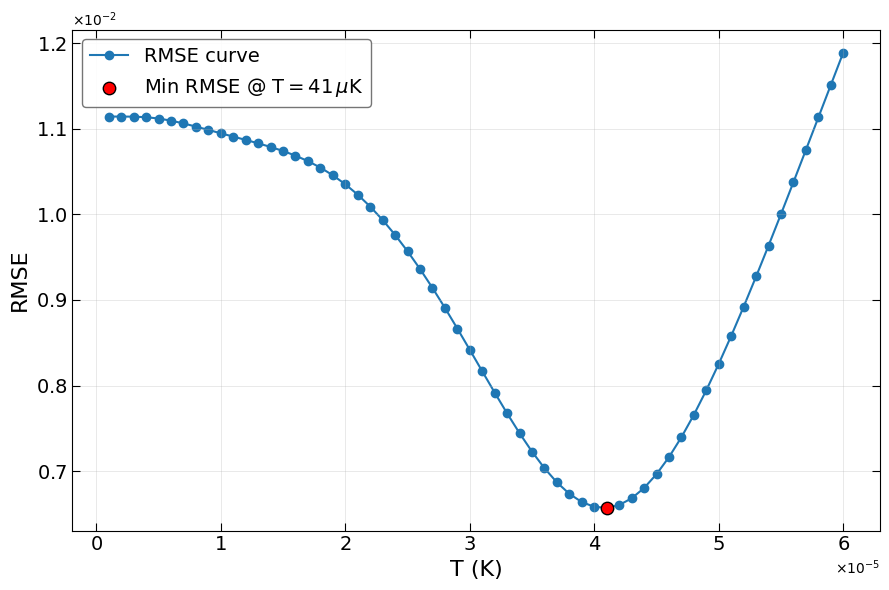

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# --- figure setup ---
fig, ax = plt.subplots(figsize=(9, 6))

# Convert T_all to float
T_all_float = [float(T) for T in T_all]

# Take first 60 points like you did in the other plot
T_window = T_all_float[0:60]
rmse_window = rmse_all[0:60]

# Find minimum RMSE and corresponding T within that window
min_index = np.argmin(rmse_window)
min_T = T_window[min_index]
min_rmse = rmse_window[min_index]

# === main curve ===
ax.plot(
    T_window,
    rmse_window,
    marker='o',
    linestyle='-',
    color='tab:blue',
    label='RMSE curve',
    zorder=1,
)

# === highlight minimum point ===
ax.scatter(
    min_T,
    min_rmse,
    color='red',
    s=80,
    edgecolor='black',
    zorder=5,
    label=fr"Min RMSE @ T$=41\,\mu\mathrm{{K}}$",
)

# === axes labels ===
ax.set_xlabel(r"T (K)", fontsize=16)
ax.set_ylabel(r"RMSE", fontsize=16)

# === tick + spine styling ===
ax.tick_params(
    axis='both',
    which='both',
    direction='in',
    top=True,
    right=True,
    labelsize=12,
    length=6,
)

# === grid ===
ax.grid(True, which='both', linewidth=0.5, alpha=0.4)

# === legend ===
ax.legend(
    loc='best',
    fontsize=14,
    frameon=True,
    facecolor='white',
    edgecolor='0.4',
    framealpha=0.9,
)

# === scientific notation (robust way) ===
x_formatter = ScalarFormatter(useMathText=True)
x_formatter.set_powerlimits((-2, 2))
x_formatter.set_scientific(True)
ax.xaxis.set_major_formatter(x_formatter)

y_formatter = ScalarFormatter(useMathText=True)
y_formatter.set_powerlimits((-2, 2))
y_formatter.set_scientific(True)
ax.yaxis.set_major_formatter(y_formatter)
ax.tick_params(labelsize=14)
# === layout ===
plt.tight_layout()
plt.show()

In [8]:
def build_qpu_samples_lists(qpu_folder, detuning_indices, max_sites, bit_value_is_occupied=0):
    qpu_samples_lists = []

    for idx in detuning_indices:
        path = os.path.join(qpu_folder, str(idx))

        pre, post = read_all_sequences_from_folder(path)
        pre = np.array(pre)
        post = np.array(post)

        # keep only shots with all atoms present
        num_atoms = pre.shape[1]
        good = (np.sum(pre, axis=1) == num_atoms)
        post = post[good]

        # convert bit convention: (post == bit_value_is_occupied) → 1 for occupied
        occ = (post == bit_value_is_occupied).astype(np.uint8)

        # concentration fraction for each shot
        conc_frac = np.sum(occ, axis=1) / max_sites

        qpu_samples_lists.append(conc_frac)

    return qpu_samples_lists

QPU Δμ from positions (eV):
  idx 0: -8.227649e-08
  idx 1: -6.856375e-08
  idx 2: -5.485100e-08
  idx 3: -4.113825e-08
  idx 4: -2.742550e-08
  idx 5: -1.371275e-08
  idx 6: -0.000000e+00
  idx 7: 1.371275e-08
  idx 8: 2.742550e-08
  idx 9: 4.113825e-08

ES μ keys from JSON (eV):
  ES[0]: -8.227649e-08
  ES[1]: -6.856375e-08
  ES[2]: -5.485100e-08
  ES[3]: -4.113825e-08
  ES[4]: -2.742550e-08
  ES[5]: -1.371275e-08
  ES[6]: -0.000000e+00
  ES[7]: 1.371275e-08
  ES[8]: 2.742550e-08
  ES[9]: 4.113825e-08
[match] panel 0: μ_qpu=-8.227649e-08, μ_ES=-8.227649e-08, |Δμ|=0.000e+00
[match] panel 1: μ_qpu=-6.856375e-08, μ_ES=-6.856375e-08, |Δμ|=0.000e+00
[match] panel 2: μ_qpu=-5.485100e-08, μ_ES=-5.485100e-08, |Δμ|=0.000e+00
[match] panel 3: μ_qpu=-4.113825e-08, μ_ES=-4.113825e-08, |Δμ|=0.000e+00
[match] panel 4: μ_qpu=-2.742550e-08, μ_ES=-2.742550e-08, |Δμ|=0.000e+00
[match] panel 5: μ_qpu=-1.371275e-08, μ_ES=-1.371275e-08, |Δμ|=0.000e+00
[match] panel 6: μ_qpu=-0.000000e+00, μ_ES=-0.000000e

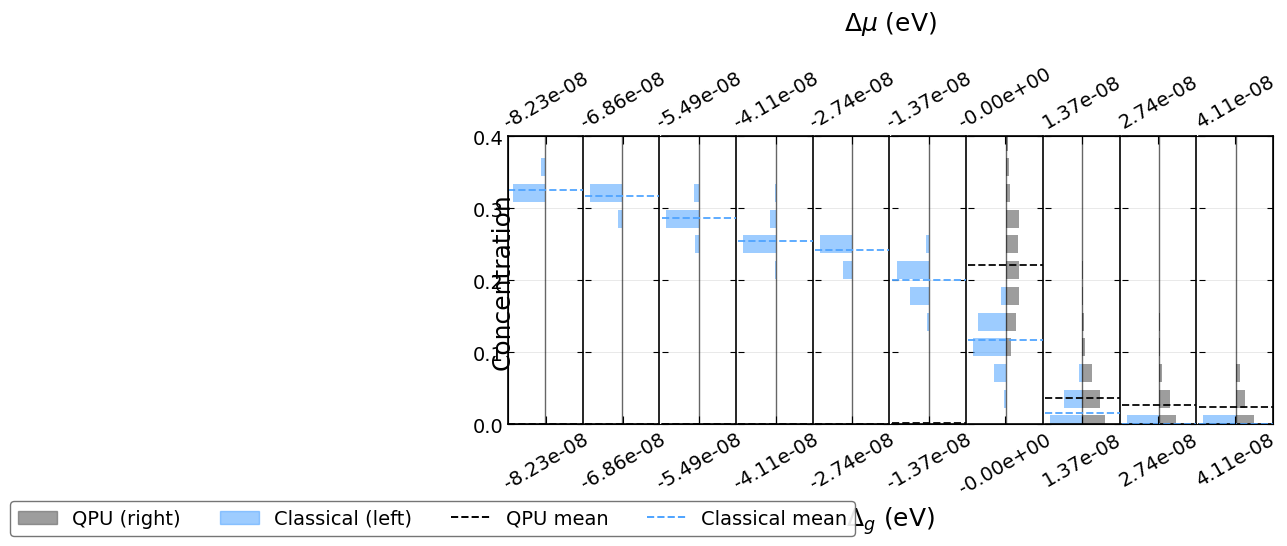

In [9]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as Patch

# ============================================================
# USER SETTINGS / INPUTS
# ============================================================

es_json_file = "data/exhaustive_search/production/conc_distribution_by_mu_T_4.1e-5.json"

max_sites     = 28      # must match ES generation
ymax_fraction = 0.4     # concentration fraction upper limit on y-axis

# Tolerance for μ matching (in eV). Your ES grid spacing is ~1e-8,
# so 5e-8 is generous but still tight.
mu_match_tol  = 5e-8

# ----------------------------------------------------------------
# qpu_samples_lists is assumed to be built in your environment, e.g.:
# ----------------------------------------------------------------
qpu_samples_lists = build_qpu_samples_lists(
    qpu_folder="qpu_data/production/3x4/4micron",
    detuning_indices=np.arange(10),
    max_sites=28,
    bit_value_is_occupied=0,
)
#
# and you already have:
#   alpha_v, reg_coef_rad_s, eV_to_rad_s
# where reg_coef_rad_s[0] = r0 in rad/s
# ----------------------------------------------------------------

# ============================================================
# Utilities
# ============================================================

def pmf_from_samples(samples, max_sites):
    """
    Convert a list/array of concentration FRACTIONS in [0,1] to a PMF over
    integer concentrations 0..max_sites.
    """
    y_levels = np.arange(max_sites + 1, dtype=float) / max_sites

    if samples is None:
        return y_levels, np.zeros(max_sites + 1, dtype=float)

    arr = np.asarray(samples)
    if arr.size == 0 or not np.isfinite(arr).any():
        return y_levels, np.zeros(max_sites + 1, dtype=float)

    # Clip to [0,1], convert to discrete counts 0..max_sites
    k = np.rint(np.clip(arr, 0, 1) * max_sites).astype(int)
    counts = np.bincount(k, minlength=max_sites + 1).astype(float)
    total = counts.sum()
    pmf = counts / total if total > 0 else np.zeros_like(counts)
    return y_levels, pmf


def load_es_map(json_path, max_sites):
    """
    Load ES distributions saved as:
      { "<mu>": {"T":..., "max_conc":..., "renormalized":..., "probs": {...}} }
    Returns:
      es_map: dict {mu_float: pmf_np}, pmf length = max_sites+1, normalized.
    """
    with open(json_path, "r") as f:
        dist_data = json.load(f)

    es_map = {}
    for k, v in dist_data.items():
        mu = float(k)
        probs = v["probs"]
        pmf = np.array(
            [float(probs.get(str(i), 0.0)) for i in range(max_sites + 1)],
            dtype=float,
        )
        s = pmf.sum()
        if s > 0:
            pmf = pmf / s
        es_map[mu] = pmf
    return es_map


def match_es_to_targets(es_map, target_mu_vals, tol=5e-8, verbose=True):
    """
    For each target μ (in eV), pick the nearest ES μ within tol.
    Returns:
      matched_pmfs: list of PMFs aligned to FOUND targets
      matched_mu  : np.array of matched ES μ
      mask_found  : boolean mask over target_mu_vals indicating which had a match
    """
    es_mus = np.array(sorted(es_map.keys()), dtype=float)
    matched_pmfs = []
    matched_mu = []
    mask_found = np.zeros(len(target_mu_vals), dtype=bool)

    for i, mu in enumerate(np.asarray(target_mu_vals, dtype=float)):
        idx = np.searchsorted(es_mus, mu)
        cand = []
        if idx > 0:
            cand.append(idx - 1)
        if idx < len(es_mus):
            cand.append(idx)
        if not cand:
            if verbose:
                print(f"[match] panel {i}: no ES μ candidates")
            continue

        best = min(cand, key=lambda j: abs(es_mus[j] - mu))
        delta = abs(es_mus[best] - mu)
        if delta <= tol:
            mask_found[i] = True
            matched_mu.append(es_mus[best])
            matched_pmfs.append(es_map[es_mus[best]])
            if verbose:
                print(f"[match] panel {i}: μ_qpu={mu:.6e}, μ_ES={es_mus[best]:.6e}, |Δμ|={delta:.3e}")
        else:
            if verbose:
                print(
                    f"[match] panel {i}: μ_qpu={mu:.6e}, nearest ES μ={es_mus[best]:.6e}, "
                    f"|Δμ|={delta:.3e} > tol {tol:.1e} (skipping)"
                )
    return matched_pmfs, np.array(matched_mu, dtype=float), mask_found


def draw_split_panel_pmfs(
    ax,
    y_levels,
    pmf_qpu,
    pmf_es,
    ymax_fraction=0.4,
    color_right='dimgray',
    color_left='#4da3ff',
    show_y_ticks=False,
):
    """
    Plot mirrored PMFs directly (no resampling):
      - Right (QPU): pmf_qpu
      - Left  (ES) : pmf_es
    """
    keep = y_levels <= ymax_fraction
    y = y_levels[keep]
    pr = pmf_qpu[keep]
    pl = pmf_es[keep]

    dy = y[1] - y[0] if len(y) > 1 else 1.0
    halfh = 0.35 * dy

    # QPU on the right
    for yi, pi in zip(y, pr):
        if pi <= 0:
            continue
        ax.fill_betweenx(
            [yi - halfh, yi + halfh],
            0, pi,
            facecolor=color_right,
            edgecolor='none',
            alpha=0.65,
            zorder=2,
        )

    # ES on the left
    for yi, pi in zip(y, pl):
        if pi <= 0:
            continue
        ax.fill_betweenx(
            [yi - halfh, yi + halfh],
            -pi, 0,
            facecolor=color_left,
            edgecolor='none',
            alpha=0.55,
            zorder=2,
        )

    # center line
    ax.axvline(0, color='k', linewidth=1.0, alpha=0.6, zorder=3)

    # means
    mean_qpu = np.sum(y * pr)
    mean_es  = np.sum(y * pl)
    ax.axhline(mean_qpu, color='k', linestyle='--', linewidth=1.4, alpha=0.9, zorder=4)
    ax.axhline(mean_es,  color=color_left, linestyle='--', linewidth=1.4, alpha=0.9, zorder=4)

    # limits
    ax.set_ylim(0, ymax_fraction)
    ax.set_yticks(np.linspace(0, ymax_fraction, 5))

    xmax = max(1e-12, pr.max() if pr.size else 0, pl.max() if pl.size else 0)
    ax.set_xlim(-1.15 * xmax, 1.15 * xmax)

    # Styling
    ax.tick_params(
        axis='y',
        which='both',
        direction='in',
        right=True,
        labelsize=14 if show_y_ticks else 0,
        length=4,
    )
    ax.tick_params(
        axis='x',
        which='both',
        direction='in',
        top=True,
        labelsize=0,
        length=4,
    )

    ax.grid(axis='y', which='both', linewidth=0.5, alpha=0.4)

    ax.spines['bottom'].set_linewidth(1.2)
    ax.spines['top'].set_linewidth(1.2)
    ax.spines['right'].set_linewidth(1.2)
    ax.spines['left'].set_linewidth(1.2 if show_y_ticks else 0.0)

    if not show_y_ticks:
        ax.set_yticklabels([])


# ============================================================
# MAIN PLOTTING
# ============================================================

# 0) We **trust** positions_arr and qpu_samples_lists lengths match
positions_arr = -np.linspace(125000000, -62500000, 10)   # Δg in rad/s for 10 detunings
N = len(positions_arr)
assert len(qpu_samples_lists) == N, "qpu_samples_lists and positions_arr must have same length"

# 1) Convert Δg → Δμ (eV) using your calibration
r0 = reg_coef_rad_s[0]
delta_mu_from_positions = (positions_arr) / eV_to_rad_s

print("QPU Δμ from positions (eV):")
for i, mu in enumerate(delta_mu_from_positions):
    print(f"  idx {i}: {mu:.6e}")

# 2) Load ES map and inspect μ keys
es_map = load_es_map(es_json_file, max_sites=max_sites)
es_mus_sorted = np.array(sorted(es_map.keys()), dtype=float)

print("\nES μ keys from JSON (eV):")
for i, mu in enumerate(es_mus_sorted[:min(10, len(es_mus_sorted))]):
    print(f"  ES[{i}]: {mu:.6e}")

# 3) Match ES μ to QPU Δμ
es_pmfs_aligned, matched_mu_vals, mask_found = match_es_to_targets(
    es_map,
    target_mu_vals=delta_mu_from_positions,
    tol=mu_match_tol,
    verbose=True,
)

# Filter positions and QPU samples to only the matched ones
positions_aligned = positions_arr[mask_found]
delta_mu_aligned  = delta_mu_from_positions[mask_found]

qpu_pmfs_all = []
y_levels = np.arange(max_sites + 1, dtype=float) / max_sites

for samples in qpu_samples_lists:
    _, pmf_qpu = pmf_from_samples(samples, max_sites=max_sites)
    qpu_pmfs_all.append(pmf_qpu)

qpu_pmfs_aligned = [qpu_pmfs_all[j] for j, keep in enumerate(mask_found) if keep]

M = len(positions_aligned)
print(f"\n[info] Panels after μ-matching: {M} / {N}")
if M == 0:
    raise RuntimeError("No panels to plot: none of the QPU μ values matched ES μ within tolerance.")

# 4) Build figure: one row, M vertical split-panels
fig = plt.figure(figsize=(min(12, 0.85 * M), 4.8))
gs = GridSpec(1, M, figure=fig, wspace=0.03)

axes_panels = []
for j in range(M):
    ax_panel = fig.add_subplot(gs[0, j])
    axes_panels.append(ax_panel)

    pmf_qpu = qpu_pmfs_aligned[j]
    pmf_es  = es_pmfs_aligned[j]

    draw_split_panel_pmfs(
        ax=ax_panel,
        y_levels=y_levels,
        pmf_qpu=pmf_qpu,
        pmf_es=pmf_es,
        ymax_fraction=ymax_fraction,
        color_right='dimgray',
        color_left='#4da3ff',
        show_y_ticks=(j == 0),
    )

    ax_panel.set_xticks([])
    ax_panel.tick_params(axis='x', length=0)

# 5) Shared y label
fig.text(0.06, 0.5, "Concentration", va="center", rotation="vertical", fontsize=18)

# --- define panel-centered tick positions in an abstract [0, M] coordinate ---
tick_pos = np.arange(M) + 0.5  # centers: 0.5, 1.5, ..., M-0.5

# 6) Shared bottom axis: Δg (rad/s) → converted to eV units like elsewhere
ax_bottom = fig.add_subplot(gs[0, :], frame_on=False)
ax_bottom.set_xlim(0, M)
ax_bottom.set_ylim(0, 1)

ax_bottom.tick_params(
    axis='both',
    which='both',
    bottom=True,
    top=False,
    labelbottom=True,
    labeltop=False,
    left=False,
    right=False,
    labelleft=False,
    labelright=False,
    direction='in',
    length=6,
    labelsize=14,
)

ax_bottom.set_xlabel(r"$\Delta_g$ (eV)", fontsize=18, labelpad=5)

# bottom labels: Δg / eV_to_rad_s for matched panels
delta_g_eV_units = positions_aligned / eV_to_rad_s
ax_bottom.set_xticks(tick_pos)
ax_bottom.set_xticklabels(
    [f"{val:.2e}" for val in delta_g_eV_units],
    rotation=30,
    ha='center',
)

ax_bottom.set_yticks([])

# 7) Shared top axis: matched Δμ (eV)
ax_top = ax_bottom.twiny()
ax_top.set_xlim(ax_bottom.get_xlim())
ax_top.set_ylim(ax_bottom.get_ylim())

ax_top.tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=True,
    labelbottom=False,
    labeltop=True,
    direction='in',
    length=6,
    labelsize=14,
)

ax_top.set_xlabel(r"$\Delta\mu$ (eV)", fontsize=18, labelpad=24)

ax_top.set_xticks(tick_pos)
ax_top.set_xticklabels(
    [f"{val:.2e}" for val in matched_mu_vals],
    rotation=30,
    ha='center',
)

# 8) Legend (QPU / Classical / means)
handles = [
    Patch.Patch(color='dimgray', alpha=0.65, label='QPU (right)'),
    Patch.Patch(color='#4da3ff', alpha=0.55, label='Classical (left)'),
    plt.Line2D([], [], color='k',       ls='--', linewidth=1.4, label='QPU mean'),
    plt.Line2D([], [], color='#4da3ff', ls='--', linewidth=1.4, label='Classical mean'),
]

fig.subplots_adjust(left=0.08, right=0.98, top=0.8, bottom=0.2)

fig.legend(
    handles=handles,
    ncol=4,
    bbox_to_anchor=(0.5, 0.06),
    fontsize=14,
    frameon=True,
    facecolor='white',
    edgecolor='0.4',
    framealpha=0.9,
)

plt.show()

In [10]:
# ============================================================
# 3D: 2D vertical histograms placed along Δμ axis (side-by-side bars)
# ============================================================

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# concentration levels
conc_levels = np.arange(max_sites + 1, dtype=float) / max_sites
n_det = len(delta_mu_qpu)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# histogram bin width in x direction
dx = conc_levels[1] - conc_levels[0]

# vertical histogram plate thickness
dy = 0.12

# transparency and colors (RGBA)
qpu_color = (0.85, 0.45, 0.10, 0.55)   # orange, alpha
es_color  = (0.10, 0.40, 0.75, 0.55)   # blue, alpha

for j in range(n_det):

    # position along Δμ axis
    y0 = j * dy

    pmf_qpu = np.array(qpu_pmfs[j])
    pmf_es  = np.array(es_pmfs[j])

    # ----------------------------
    #   Side-by-side bar positions
    # ----------------------------
    x_qpu = conc_levels - dx/4
    x_es  = conc_levels + dx/4

    # QPU histogram
    ax.bar(
        x_qpu, pmf_qpu,
        zs=y0, zdir='y',
        width=dx/2,
        alpha=qpu_color[3],
        color=qpu_color[:3],
        edgecolor='none'
    )

    # ES histogram
    ax.bar(
        x_es, pmf_es,
        zs=y0, zdir='y',
        width=dx/2,
        alpha=es_color[3],
        color=es_color[:3],
        edgecolor='none'
    )

# ---------------- Axis cosmetics ----------------
ax.set_xlabel("Concentration fraction", labelpad=12, fontsize=14)
ax.set_ylabel(r"$\Delta\mu$ (eV)", labelpad=12, fontsize=14)
ax.set_zlabel("Probability", labelpad=12, fontsize=14)

# y-ticks (Δμ values)
ax.set_yticks([j * dy for j in range(n_det)])
ax.set_yticklabels([f"{mu:.2e}" for mu in delta_mu_qpu], fontsize=10)

# limits
ax.set_zlim(0, max(p.max() for p in (qpu_pmfs + es_pmfs)) * 1.1)
ax.set_xlim(0, 0.4)

# camera angle
ax.view_init(elev=28, azim=-60)

# grid appearance
for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
    axis._axinfo["grid"]['linestyle'] = ':'
    axis._axinfo["grid"]['linewidth'] = 0.5
    axis._axinfo["grid"]['color'] = (0.7, 0.7, 0.7, 0.6)

# ---------------- Legend ----------------
handles = [
    plt.Line2D([0], [0], color=qpu_color[:3], lw=10, alpha=qpu_color[3]),
    plt.Line2D([0], [0], color=es_color[:3],  lw=10, alpha=es_color[3]),
]
labels = [
    "QPU",
    r"ES, $T = 4.1\times10^{-5}\,\mathrm{K}$",
]

ax.legend(
    handles=handles,
    labels=labels,
    loc="upper left",
    bbox_to_anchor=(0.0, 1.0),
    fontsize=12,
    frameon=True
)

plt.tight_layout()
plt.show()

NameError: name 'delta_mu_qpu' is not defined

In [ ]:
import os
import json
import numpy as np

# ------------------------ QPU side ------------------------ #

def pmf_from_samples(samples, max_sites):
    """
    Turn a 1D array of concentration fractions in [0,1] into a PMF over
    integer occupations k = 0..max_sites.
    """
    y_levels = np.arange(max_sites + 1, dtype=float) / max_sites
    samples = np.asarray(samples, dtype=float)

    if samples.size == 0 or not np.isfinite(samples).any():
        return y_levels, np.zeros(max_sites + 1, dtype=float)

    k = np.rint(np.clip(samples, 0.0, 1.0) * max_sites).astype(int)
    counts = np.bincount(k, minlength=max_sites + 1).astype(float)
    total = counts.sum()
    pmf = counts / total if total > 0 else np.zeros_like(counts)
    return y_levels, pmf


def build_qpu_samples_and_pmfs(
    qpu_folder,
    detuning_indices,
    max_sites,
    *,
    bit_value_is_occupied=0,
    eV_to_rad_s=None,
    alpha_v=None,
    reg_coef_rad_s=None,
):
    """
    Build QPU PMFs and Δμ(eV) for each detuning index.
    """
    qpu_samples_lists = []
    qpu_pmfs = []
    delta_mu_list = []

    detuning_indices = list(detuning_indices)

    for det_idx in detuning_indices:
        path = os.path.join(qpu_folder, str(det_idx))

        # your existing helpers:
        preseqs, postseqs = read_all_sequences_from_folder(path)
        preseqs = stack_chunks_vertically(np.array(preseqs))
        postseqs = stack_chunks_vertically(np.array(postseqs))

        if preseqs.ndim != 2 or postseqs.ndim != 2:
            raise RuntimeError(
                f"[detuning {det_idx}] Expected 2D arrays, got "
                f"{preseqs.shape} and {postseqs.shape}"
            )
        if preseqs.shape[1] != postseqs.shape[1]:
            raise RuntimeError(
                f"[detuning {det_idx}] Pre/Post mismatch: "
                f"{preseqs.shape[1]} vs {postseqs.shape[1]}"
            )

        num_atoms = preseqs.shape[1]

        # keep only well-prepared shots
        keep_mask = (preseqs.sum(axis=1) == num_atoms)
        postseqs_f = postseqs[keep_mask]

        if postseqs_f.size == 0:
            qpu_samples_lists.append(np.array([]))
            qpu_pmfs.append(np.zeros(max_sites + 1))
            if eV_to_rad_s is not None:
                delta_mu_list.append(np.nan)
            continue

        # convert to occupation (1 = occupied)
        occ = (postseqs_f == bit_value_is_occupied).astype(np.uint8)
        conc_per_shot = occ.sum(axis=1) / float(num_atoms)

        qpu_samples_lists.append(conc_per_shot)

        _, pmf_qpu = pmf_from_samples(conc_per_shot, max_sites=max_sites)
        qpu_pmfs.append(pmf_qpu)

        # Δμ(eV) from calibration (if provided)
        if (eV_to_rad_s is not None) and (alpha_v is not None) and (reg_coef_rad_s is not None):
            delta_g_hw = -extract_detuning_values(path)[-1]  # rad/s, your convention
            r0 = float(reg_coef_rad_s[0])
            delta_mu = (-r0 + alpha_v * delta_g_hw) / eV_to_rad_s
            delta_mu_list.append(delta_mu)

    delta_mu_qpu = np.array(delta_mu_list, dtype=float) if delta_mu_list else None
    return qpu_samples_lists, qpu_pmfs, delta_mu_qpu


# ------------------------ ES side ------------------------ #

def load_es_pmfs_from_mu_json(json_path, max_sites):
    """
    Load ES PMFs from a file like:
      { "<mu>": {"probs": {"0": p0, "1": p1, ...}}, ... }

    Returns
    -------
    es_pmfs      : list of np.ndarray, each length max_sites+1
    delta_mu_es  : np.ndarray of μ values (floats), same order.
    """
    with open(json_path, "r") as f:
        data = json.load(f)

    mus = sorted(data.keys(), key=lambda s: float(s))
    es_pmfs = []
    delta_mu_es = []

    for mu_str in mus:
        mu = float(mu_str)
        probs_dict = data[mu_str]["probs"]
        pmf = np.array(
            [float(probs_dict.get(str(k), 0.0)) for k in range(max_sites + 1)],
            dtype=float
        )
        s = pmf.sum()
        if s > 0:
            pmf = pmf / s
        es_pmfs.append(pmf)
        delta_mu_es.append(mu)

    return es_pmfs, np.array(delta_mu_es, dtype=float)





In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_stacked_pmf_panels(
    qpu_pmfs,
    es_pmfs,
    delta_mu_qpu,
    max_sites,
    max_conc_fraction=0.5,
    panel_indices=None,
    qpu_color="#E69F00",      # warm orange
    es_color="#4C72B0",       # muted blue
):
    """
    Stacked QPU vs ES PMF panels.

    - shared x-axis: concentration fraction \overline{[N]}
    - per-row y-axis: Probability (global label on the left)
    - each row j: bar plot of QPU vs ES at Δμ_j with vertical lines at means
    """

    # --- basic checks / prep ---
    qpu_pmfs = [np.asarray(p, dtype=float) for p in qpu_pmfs]
    es_pmfs  = [np.asarray(p, dtype=float) for p in es_pmfs]
    delta_mu_qpu = np.asarray(delta_mu_qpu, dtype=float)

    n_det_total = len(delta_mu_qpu)
    assert len(qpu_pmfs) == n_det_total == len(es_pmfs), "Lengths must match"

    if panel_indices is None:
        panel_indices = list(reversed(range(n_det_total)))
    panel_indices = list(panel_indices)
    n_panels = len(panel_indices)

    conc_levels = np.arange(max_sites + 1, dtype=float) / max_sites
    dx = conc_levels[1] - conc_levels[0]
    bar_width = dx * 0.38

    # global y-limit so scales are comparable
    global_ymax = 0.0
    for j in panel_indices:
        global_ymax = max(global_ymax, qpu_pmfs[j].max(), es_pmfs[j].max())
    if global_ymax == 0:
        global_ymax = 1.0

    # --- larger fonts ---
    plt.rcParams.update({
        "font.size": 13,
        "axes.labelsize": 15,
        "axes.titlesize": 13,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
    })

    fig_height = max(2.0, 1.6 * n_panels)
    fig, axes = plt.subplots(
        n_panels, 1,
        sharex=True,
        figsize=(7.5, fig_height),
    )
    if n_panels == 1:
        axes = [axes]

    # --- draw each panel ---
    for ax, j in zip(axes, panel_indices):
        pmf_qpu = qpu_pmfs[j]
        pmf_es  = es_pmfs[j]

        x_qpu = conc_levels - bar_width/2
        x_es  = conc_levels + bar_width/2

        # QPU bars
        ax.bar(
            x_qpu, pmf_qpu,
            width=bar_width,
            color=qpu_color,
            alpha=0.85,
            label="QPU" if j == panel_indices[0] else None,
            edgecolor="none",
        )

        # ES bars
        ax.bar(
            x_es, pmf_es,
            width=bar_width,
            color=es_color,
            alpha=0.80,
            label=r"ES, $T = 4.1\times10^{-5}\,\mathrm{K}$" if j == panel_indices[0] else None,
            edgecolor="none",
        )

        # vertical lines at the mean concentration (⟨[N]⟩) for each
        mean_qpu = np.sum(conc_levels * pmf_qpu)
        mean_es  = np.sum(conc_levels * pmf_es)
        ax.axvline(mean_qpu, color=qpu_color, linestyle='--', linewidth=1.6, alpha=0.9)
        ax.axvline(mean_es,  color=es_color,  linestyle='--', linewidth=1.6, alpha=0.9)

        # y-axis & grid
        ax.set_ylim(0, global_ymax * 1.05)
        ax.tick_params(axis='y', direction='in', right=True, length=4)
        ax.grid(axis='y', linestyle=':', linewidth=0.5, alpha=0.35)

        # de-emphasise spines
        for spine in ["top", "right"]:
            ax.spines[spine].set_visible(False)
        for spine in ["left", "bottom"]:
            ax.spines[spine].set_linewidth(0.9)
            ax.spines[spine].set_color("0.3")

        # Δμ annotation in x10^ format, small box
        mu = np.round(delta_mu_qpu[j],10)
        mant, exp = f"{mu:.2e}".split("e")
        mant = float(mant)
        exp = int(exp)
        mu_str = rf"$\Delta\mu = {mant:.2f}\times10^{{{exp}}}\,\mathrm{{eV}}$"

        ax.text(
            0.98, 0.80,
            mu_str,
            transform=ax.transAxes,
            ha="right",
            va="center",
            fontsize=11,
            bbox=dict(
                boxstyle="round,pad=0.25",
                facecolor="white",
                edgecolor="0.8",
                alpha=0.9,
            ),
        )

        # no per-panel y-label; global one will be added
        ax.set_ylabel("")

    # --- shared x-axis ---
    axes[-1].set_xlim(0, max_conc_fraction)
    axes[-1].set_xlabel(r"$\overline{[N]}$", fontsize=16)
    axes[-1].tick_params(axis='x', direction='in', top=True, length=4)

    # nice x ticks
    x_max = max_conc_fraction
    step = 0.1
    xticks = np.arange(0, x_max + 1e-9, step)
    axes[-1].set_xticks(xticks)

    # --- global y-label in the centre left ---
    fig.text(
        0.02, 0.5,
        "Probability",
        va="center",
        ha="center",
        rotation="vertical",
        fontsize=16,
    )

    # --- legend: top left of top panel ---
    axes[0].legend(
        loc="upper center",
        fontsize=13,
        frameon=True,
        facecolor="white",
        edgecolor="0.5",
        framealpha=0.9,
    )

    plt.tight_layout(rect=(0.05, 0.05, 0.98, 0.97))
    plt.show()



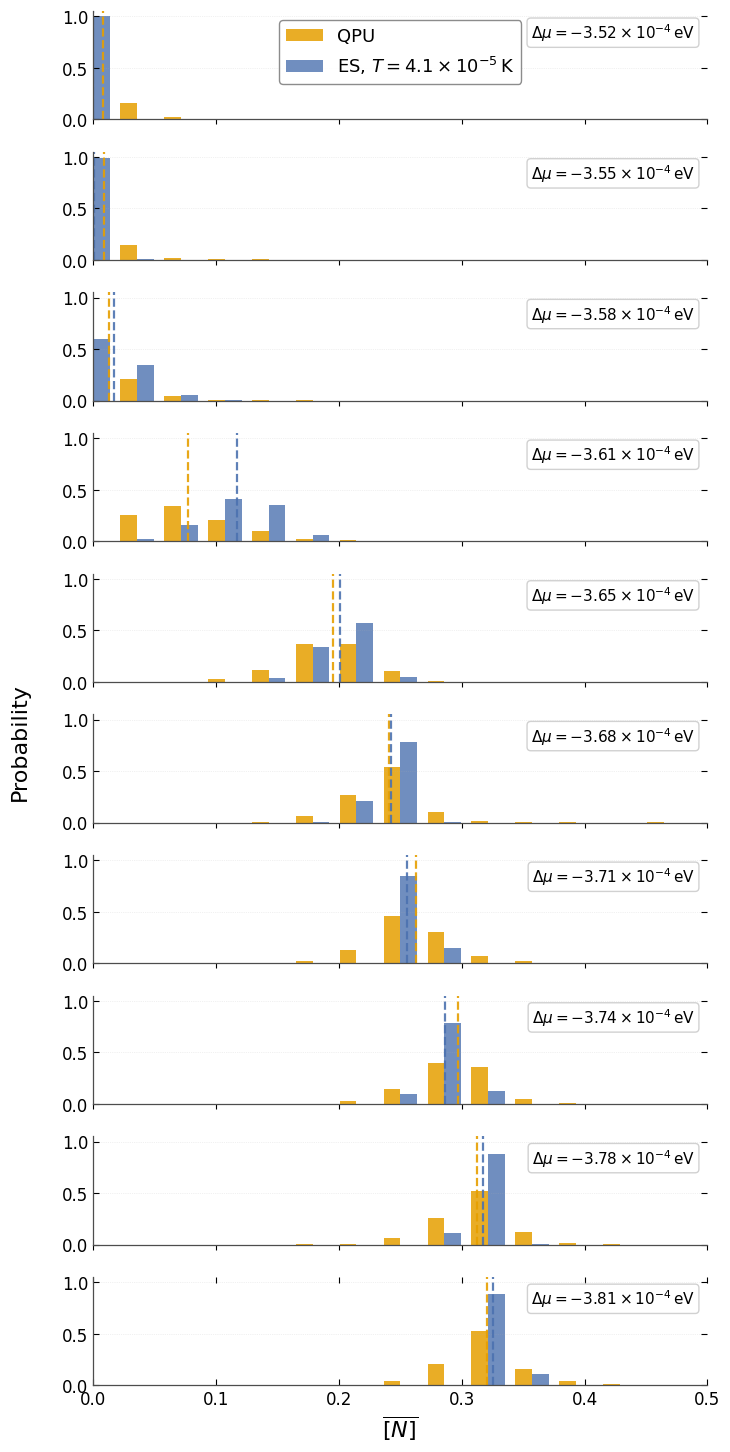

In [ ]:
max_sites = 28

# 1) QPU side
qpu_samples_lists, qpu_pmfs, delta_mu_qpu = build_qpu_samples_and_pmfs(
    qpu_folder="qpu_data/production/3x4/4micron",
    detuning_indices=np.arange(10),
    max_sites=max_sites,
    bit_value_is_occupied=0,
    eV_to_rad_s=eV_to_rad_s,
    alpha_v=alpha_v,
    reg_coef_rad_s=reg_coef,   # your calibration array
)

# 2) ES side (T = 4.1e-5 K file)
es_pmfs_all, delta_mu_es = load_es_pmfs_from_mu_json(
    "data/exhaustive_search/production/conc_distribution_by_mu_T_4.1e-5.json",
    max_sites=max_sites,
)

# If grids are the same length and order, you can just truncate to the min length:
n = min(len(qpu_pmfs), len(es_pmfs_all))
qpu_pmfs_use = qpu_pmfs[:n]
es_pmfs_use  = es_pmfs_all[:n]
delta_mu_use = (delta_mu_qpu if delta_mu_qpu is not None else delta_mu_es)[:n]
delta_mu_use = delta_g_all_int_neg_ticks*alpha_v-reg_coef[0]

# 3) Now call your stacked-panel plot
plot_stacked_pmf_panels(
    qpu_pmfs=qpu_pmfs_use,
    es_pmfs=es_pmfs_use,
    delta_mu_qpu=delta_mu_use,
    max_sites=max_sites,
    max_conc_fraction=0.5,
    # panel_indices=[0, 2, 4, 6, 8],  # optional subset
)

## Num states vs Energy

In [ ]:
# 2) Your 28 coordinates array (meters) – use the one you posted
coords = np.array([
 [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
 [-2.00500000e-06,  3.47276187e-06,  0.00000000e+00],
 [ 0.00000000e+00 , 6.94552374e-06,  0.00000000e+00],
 [-2.00500000e-06,  1.04182856e-05,  0.00000000e+00],
 [ 0.00000000e+00,  1.38910475e-05,  0.00000000e+00],
 [-2.00500000e-06,  1.73638093e-05,  0.00000000e+00],
 [ 0.00000000e+00,  2.08365712e-05,  0.00000000e+00],
 [ 4.01000000e-06,  0.00000000e+00,  0.00000000e+00],
 [ 6.01500000e-06,  3.47276187e-06,  0.00000000e+00],
 [ 4.01000000e-06,  6.94552374e-06,  0.00000000e+00],
 [ 6.01500000e-06,  1.04182856e-05,  0.00000000e+00],
 [ 4.01000000e-06,  1.38910475e-05,  0.00000000e+00],
 [ 6.01500000e-06,  1.73638093e-05,  0.00000000e+00],
 [ 4.01000000e-06,  2.08365712e-05,  0.00000000e+00],
 [ 1.20300000e-05,  0.00000000e+00,  0.00000000e+00],
 [ 1.00250000e-05,  3.47276187e-06,  0.00000000e+00],
 [ 1.20300000e-05,  6.94552374e-06,  0.00000000e+00],
 [ 1.00250000e-05,  1.04182856e-05,  0.00000000e+00],
 [ 1.20300000e-05,  1.38910475e-05,  0.00000000e+00],
 [ 1.00250000e-05,  1.73638093e-05,  0.00000000e+00],
 [ 1.20300000e-05,  2.08365712e-05,  0.00000000e+00],
 [ 1.60400000e-05,  0.00000000e+00,  0.00000000e+00],
 [ 1.80450000e-05,  3.47276187e-06,  0.00000000e+00],
 [ 1.60400000e-05,  6.94552374e-06,  0.00000000e+00],
 [ 1.80450000e-05,  1.04182856e-05,  0.00000000e+00],
 [ 1.60400000e-05,  1.38910475e-05,  0.00000000e+00],
 [ 1.80450000e-05,  1.73638093e-05,  0.00000000e+00],
 [ 1.60400000e-05,  2.08365712e-05,  0.00000000e+00]])

# 3) Call the function for one detuning
df_qpu, meta = compute_qpu_state_energies_for_mu(
    qpu_folder='qpu_data/production/3x4/4micron',
    detuning_index=0,                     # <- pick the one you want
    coordinates=coords,
    read_all_sequences_from_folder=read_all_sequences_from_folder,
    stack_chunks_vertically=stack_chunks_vertically,
    extract_detuning_values=extract_detuning_values,
    C6_rad_m6_per_s=5.42e-24,
    EV_TO_RAD_S=1.519267447321156e15,
    reg_coef_rad_s0=reg_coef_rad_s[0],   # if you have this defined in the notebook
    alpha_v=alpha_v,                      # "
    bit_value_is_occupied=0,             # keep your convention
    save_csv_path="qpu_states_energy_mu_idx0.csv"
)

df_qpu.head(), meta

(   shot_index  conc     energy_eV  energy_plus_mu_eV  delta_g_rad_per_s  \
 0           0     9  1.443951e-07      -5.960933e-07       -125000000.0   
 1           1     9  1.306431e-07      -6.098454e-07       -125000000.0   
 2           2     9  1.306431e-07      -6.098454e-07       -125000000.0   
 3           3     8  7.931413e-08      -5.788978e-07       -125000000.0   
 4           4     9  1.011489e-06       2.710007e-07       -125000000.0   
 
     delta_mu_eV                     bitstring  
 0 -8.227649e-08  0110110111011101111011010110  
 1 -8.227649e-08  0110110101110111101110110110  
 2 -8.227649e-08  0110110111011110111010110110  
 3 -8.227649e-08  0110110101111111101110110110  
 4 -8.227649e-08  1010110111011101111100101011  ,
 {'detuning_index': 0,
  'num_shots': 1203,
  'num_atoms': 28,
  'delta_g_rad_per_s': -125000000.0,
  'delta_mu_eV': -8.227649464905332e-08,
  'bit_convention': '0 => occupied',
  'notes': 'Energies of QPU-observed states; classical pair energy pl

In [ ]:
# 2) Your 28 coordinates array (meters) – use the one you posted
coords = np.array([
 [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
 [-2.00500000e-06,  3.47276187e-06,  0.00000000e+00],
 [ 0.00000000e+00 , 6.94552374e-06,  0.00000000e+00],
 [-2.00500000e-06,  1.04182856e-05,  0.00000000e+00],
 [ 0.00000000e+00,  1.38910475e-05,  0.00000000e+00],
 [-2.00500000e-06,  1.73638093e-05,  0.00000000e+00],
 [ 0.00000000e+00,  2.08365712e-05,  0.00000000e+00],
 [ 4.01000000e-06,  0.00000000e+00,  0.00000000e+00],
 [ 6.01500000e-06,  3.47276187e-06,  0.00000000e+00],
 [ 4.01000000e-06,  6.94552374e-06,  0.00000000e+00],
 [ 6.01500000e-06,  1.04182856e-05,  0.00000000e+00],
 [ 4.01000000e-06,  1.38910475e-05,  0.00000000e+00],
 [ 6.01500000e-06,  1.73638093e-05,  0.00000000e+00],
 [ 4.01000000e-06,  2.08365712e-05,  0.00000000e+00],
 [ 1.20300000e-05,  0.00000000e+00,  0.00000000e+00],
 [ 1.00250000e-05,  3.47276187e-06,  0.00000000e+00],
 [ 1.20300000e-05,  6.94552374e-06,  0.00000000e+00],
 [ 1.00250000e-05,  1.04182856e-05,  0.00000000e+00],
 [ 1.20300000e-05,  1.38910475e-05,  0.00000000e+00],
 [ 1.00250000e-05,  1.73638093e-05,  0.00000000e+00],
 [ 1.20300000e-05,  2.08365712e-05,  0.00000000e+00],
 [ 1.60400000e-05,  0.00000000e+00,  0.00000000e+00],
 [ 1.80450000e-05,  3.47276187e-06,  0.00000000e+00],
 [ 1.60400000e-05,  6.94552374e-06,  0.00000000e+00],
 [ 1.80450000e-05,  1.04182856e-05,  0.00000000e+00],
 [ 1.60400000e-05,  1.38910475e-05,  0.00000000e+00],
 [ 1.80450000e-05,  1.73638093e-05,  0.00000000e+00],
 [ 1.60400000e-05,  2.08365712e-05,  0.00000000e+00]])

# 3) Call the function for one detuning
df_qpu, meta = compute_qpu_state_energies_for_mu(
    qpu_folder='qpu_data/production/3x4/4micron',
    detuning_index=6,                     # <- pick the one you want
    coordinates=coords,
    read_all_sequences_from_folder=read_all_sequences_from_folder,
    stack_chunks_vertically=stack_chunks_vertically,
    extract_detuning_values=extract_detuning_values,
    C6_rad_m6_per_s=5.42e-24,
    EV_TO_RAD_S=1.519267447321156e15,
    reg_coef_rad_s0=reg_coef_rad_s[0],   # if you have this defined in the notebook
    alpha_v=alpha_v,                      # "
    bit_value_is_occupied=0,             # keep your convention
    save_csv_path="qpu_states_energy_mu_idx0.csv"
)

df_qpu.head(), meta

(   shot_index  conc     energy_eV  energy_plus_mu_eV  delta_g_rad_per_s  \
 0           0     2  4.965410e-10       4.965410e-10               -0.0   
 1           1     3  3.196392e-08       3.196392e-08               -0.0   
 2           2     2  4.965410e-10       4.965410e-10               -0.0   
 3           3     3  1.244874e-09       1.244874e-09               -0.0   
 4           4     2  3.905429e-10       3.905429e-10               -0.0   
 
    delta_mu_eV                     bitstring  
 0         -0.0  1111111111111110111011111111  
 1         -0.0  1111010111111111111111111101  
 2         -0.0  1111111111101111111111101111  
 3         -0.0  1111110011111111111101111111  
 4         -0.0  1011111111111101111111111111  ,
 {'detuning_index': 6,
  'num_shots': 1212,
  'num_atoms': 28,
  'delta_g_rad_per_s': -0.0,
  'delta_mu_eV': -0.0,
  'bit_convention': '0 => occupied',
  'notes': 'Energies of QPU-observed states; classical pair energy plus μ·N_occ.'})

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.patches as Patch

def plot_classical_binned_vs_qpu_dual_axis(
    classical_csv,
    df_qpu,
    use_energy_with_mu=True,
    normalize=True,
    shift_fraction=0.5,
    xmax_fixed=2.5e-5,
    mu_value = None
):
    """
    Compare classical exhaustive-search (binned CSV) vs QPU sampled distribution
    with twin y-axes, using bar charts for both.

    - classical_csv must have columns:
        edge_left_eV, edge_right_eV, count
      (these describe a histogram over energy for one μ)

    - df_qpu must have either:
        energy_plus_mu_eV  (if use_energy_with_mu=True)
        energy_eV          (if use_energy_with_mu=False)

    Steps:
      1. Build a COMMON set of bin edges that spans BOTH datasets.
      2. Histogram both onto those shared bins.
      3. Plot QPU (orange, left axis) and Classical (blue, right axis),
         with a slight x-shift and a sensible bar width.
    """

    # --- Load classical binned data ---
    df_class = pd.read_csv(classical_csv)
    left_edges_raw  = df_class["edge_left_eV"].to_numpy(dtype=float)
    right_edges_raw = df_class["edge_right_eV"].to_numpy(dtype=float)
    class_counts_raw = df_class["count"].to_numpy(dtype=float)

    # Bin centers of the original classical histogram
    class_bin_centers_raw = 0.5 * (left_edges_raw + right_edges_raw)

    # --- Pick QPU energy column ---
    if use_energy_with_mu:
        if "energy_plus_mu_eV" not in df_qpu.columns:
            raise KeyError("df_qpu must contain 'energy_plus_mu_eV' when use_energy_with_mu=True")
        qpu_energy = df_qpu["energy_plus_mu_eV"].to_numpy(dtype=float)
        x_label = r"$E$ (eV)"
    else:
        if "energy_eV" not in df_qpu.columns:
            raise KeyError("df_qpu must contain 'energy_eV' when use_energy_with_mu=False")
        qpu_energy = df_qpu["energy_eV"].to_numpy(dtype=float)
        x_label = r"$E$ (eV)"

    # --- Build common bin edges spanning BOTH ranges ---
    n_class_bins = len(class_counts_raw)

    global_xmin = min(qpu_energy.min(), left_edges_raw.min())
    global_xmax = max(qpu_energy.max(), right_edges_raw.max())

    common_edges = np.linspace(global_xmin, global_xmax, n_class_bins + 1)
    common_centers = 0.5 * (common_edges[:-1] + common_edges[1:])
    common_widths  = (common_edges[1:] - common_edges[:-1])

    # --- Re-hist classical onto the common edges ---
    classical_proxy_energies = class_bin_centers_raw
    classical_proxy_weights  = class_counts_raw

    classical_hist_counts, _ = np.histogram(
        classical_proxy_energies,
        bins=common_edges,
        weights=classical_proxy_weights
    )

    # --- Histogram QPU onto same common edges ---
    qpu_hist_counts, _ = np.histogram(qpu_energy, bins=common_edges)

    # --- Normalize to probability if requested ---
    if normalize:
        if classical_hist_counts.sum() > 0:
            classical_prob = classical_hist_counts / classical_hist_counts.sum()
        else:
            classical_prob = classical_hist_counts.astype(float)

        if qpu_hist_counts.sum() > 0:
            qpu_prob = qpu_hist_counts / qpu_hist_counts.sum()
        else:
            qpu_prob = qpu_hist_counts.astype(float)
    else:
        classical_prob = classical_hist_counts.astype(float)
        qpu_prob = qpu_hist_counts.astype(float)

    # --- X positions and bar widths ---
    avg_bin_width = np.mean(common_widths) if len(common_widths) > 0 else 0.0

    # small shift so the two bar sets are side-by-side but still “on” the same bins
    qpu_shift = avg_bin_width * shift_fraction * 0.5
    qpu_centers_shifted = common_centers - qpu_shift
    cls_centers_shifted = common_centers + qpu_shift

    # reasonable bar width (slightly less than full bin width, split between the two)
    bar_width = avg_bin_width * (1.0 - shift_fraction)

    # --- Create figure and twin y-axes ---
    fig, ax1 = plt.subplots(figsize=(9, 4.8))
    ax2 = ax1.twinx()

    # --- Plot QPU (orange, left y-axis) ---
    ax1.bar(
        qpu_centers_shifted,
        qpu_prob,
        width=bar_width,
        align="center",
        color='#E69F00',      # color-blind friendly orange
        edgecolor='#E69F00',
        alpha=0.8,
        label='QPU',
        zorder=3,
    )

    # --- Plot Classical (blue, right y-axis) ---
    ax2.bar(
        cls_centers_shifted,
        classical_prob,
        width=bar_width,
        align="center",
        color='tab:blue',
        edgecolor='tab:blue',
        alpha=0.7,
        label='Classical (ES)',
        zorder=2,
    )

    # --- Labels ---
    ax1.set_xlabel(x_label, fontsize=16)
    ax1.set_ylabel("QPU probability", fontsize=16, color='#E69F00', labelpad=5)
    ax2.set_ylabel("Classical probability", fontsize=16, color='tab:blue', labelpad=8)

    # --- Styling (Nature-ish) ---
    for ax in [ax1, ax2]:
        ax.tick_params(
            axis='both',
            which='both',
            direction='in',
            top=True,
            right=True,
            labelsize=12,
            length=6,
        )
        ax.grid(True, which='both', linewidth=0.5, alpha=0.4)

    # color ticks to match axes labels
    ax1.tick_params(axis='y', colors='#E69F00')
    ax2.tick_params(axis='y', colors='tab:blue')

    # --- Add textbox with the potential value ---
    potential_value = float(mu_value)   # or whatever variable holds Δμ or μ
    ax1.text(
        0.65, 0.50,                     # position in Axes coordinates (2% from left, 95% from top)
        rf"$\Delta\mu = {potential_value:.2e}\ \mathrm{{eV}}$",
        transform=ax1.transAxes,
        fontsize=14,
        verticalalignment='top',
        bbox=dict(
            facecolor='white',
            edgecolor='black',
            alpha=0.8,
            pad=6
        )
    )

    # --- X limits ---
    pad = 0.05 * (global_xmax - global_xmin)
    xmin_plot = global_xmin - pad
    xmax_plot = xmax_fixed if xmax_fixed is not None else (global_xmax + pad)
    ax1.set_xlim(xmin_plot, xmax_plot)

    # --- Legend (top right, single box) ---
    handles = [
        plt.Line2D([], [], color='#E69F00', lw=4.0, label='QPU'),
        plt.Line2D([], [], color='tab:blue', lw=4.0, label='Classical (ES)'),
    ]
    ax1.legend(
        handles=handles,
        loc='upper right',
        fontsize=12,
        frameon=True,
        facecolor='white',
        edgecolor='0.4',
        framealpha=0.9,
    )

    # --- Debug prints so you can sanity check ranges in notebook ---
    print("QPU energy range (used column):", qpu_energy.min(), qpu_energy.max())
    print("Classical edges range:        ", left_edges_raw.min(), right_edges_raw.max())
    print("Common edges range:           ", common_edges[0], common_edges[-1])

    plt.tight_layout()
    plt.show()

QPU energy range (used column): 0.0 1.7549377728182793e-06
Classical edges range:         0.0 3.2347e-05
Common edges range:            0.0 3.2347e-05


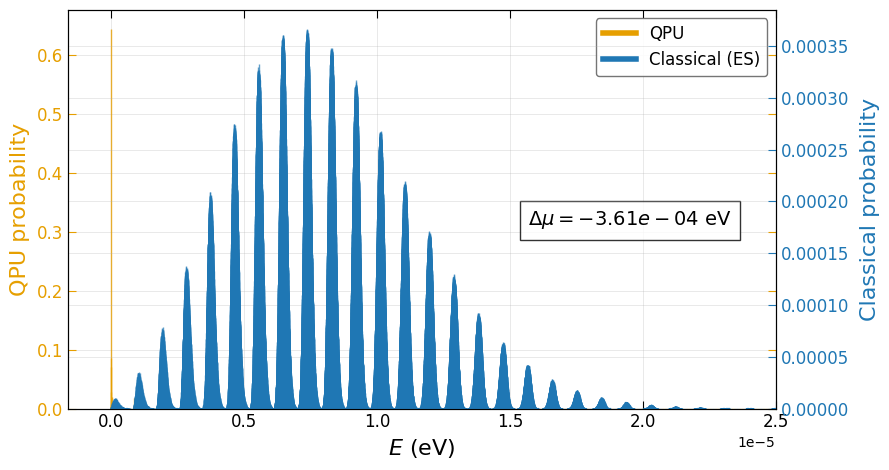

In [ ]:
# classical_csv = "data/exhaustive_search/production/num_states_vs_energy__mu=-8.2290981e-08.csv"
classical_csv = "data/exhaustive_search/production/num_states_vs_energy__mu=0.csv"

plot_classical_binned_vs_qpu_dual_axis(
    classical_csv=classical_csv,
    df_qpu=df_qpu,
    use_energy_with_mu=True,   # compares E + Nμ
    normalize=True, 
    # mu_value = -3.81e-4
    mu_value = -3.61e-4        # probability instead of raw counts
)

In [ ]:
print("QPU energy range (E + Nμ):", df_qpu["energy_plus_mu_eV"].min(), df_qpu["energy_plus_mu_eV"].max())
import pandas as pd
df_class = pd.read_csv("data/exhaustive_search/production/num_states_vs_energy__mu=-8.2290981e-08.csv")
print("Classical bin range:", df_class["edge_left_eV"].min(), df_class["edge_right_eV"].max())

QPU energy range (E + Nμ): -0.00028535539941972103 -9.732602262674227e-05
Classical bin range: -6.099757766339358e-07 3.0043024223366064e-05


In [ ]:
def plot_classical_line_vs_qpu_bars_dual_y(
    classical_csv_path: str,
    df_qpu: pd.DataFrame,
    *,
    use_energy_with_mu=True,
    normalize=False,
    figsize=(7,4)
):
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np

    cls = pd.read_csv(classical_csv_path)
    edges = np.concatenate([cls["edge_left_eV"], [cls["edge_right_eV"].iloc[-1]]])
    cls_counts = cls["count"].to_numpy(float)
    if normalize:
        cls_counts /= cls_counts.sum()

    E_qpu = df_qpu["energy_plus_mu_eV" if use_energy_with_mu else "energy_eV"].to_numpy(float)
    mu_val = float(df_qpu["delta_mu_eV"].iloc[0]) if "delta_mu_eV" in df_qpu else None

    qpu_counts, _ = np.histogram(E_qpu, bins=edges)
    if normalize:
        qpu_counts = qpu_counts / qpu_counts.sum() if qpu_counts.sum() > 0 else qpu_counts

    fig, ax1 = plt.subplots(figsize=figsize)
    ax2 = ax1.twinx()

    # Classical
    ax1.stairs(cls_counts, edges, color="k", label="Classical")
    ax1.set_ylabel("Classical count", color="k")

    # QPU
    bin_widths = np.diff(edges)
    ax2.bar(edges[:-1], qpu_counts, width=bin_widths, align="edge",
            color="#ff0000", alpha=0.55, label="QPU (bars)")
    ax2.set_ylabel("QPU count", color="#ff0000")
    ax2.set_ylim([0,20])

    ax1.set_xlabel("Energy (eV)")
    title_mu = f" at μ = {mu_val:.3e} eV" if mu_val is not None else ""
    ax1.set_title(f"Classical vs QPU energy distribution{title_mu}")
    ax1.grid(axis="y", linestyle=":", alpha=0.3)

    # Combine legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc="upper right")

    plt.tight_layout()
    plt.show()

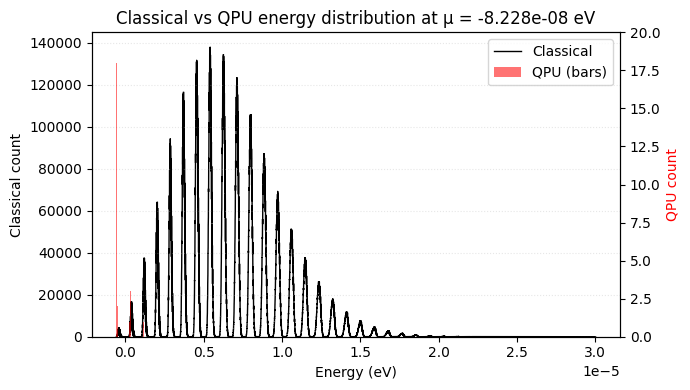

In [ ]:
plot_classical_line_vs_qpu_bars_dual_y(classical_csv, df_qpu)

Non stacked

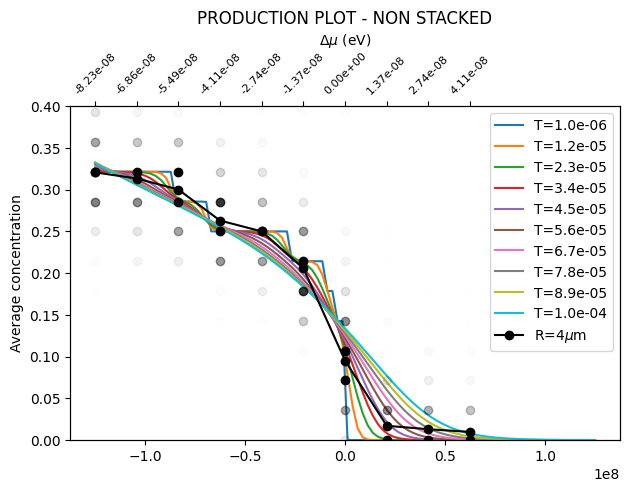

In [ ]:
fig, ax = plt.subplots()
# Hardware Δg values (positive strings)
# delta_g_all = ['125000000', '62500000', '31250000', '15625000', '0', '-31250000']
# delta_g_all_int_neg = [-int(x) for x in delta_g_all]  # Convert to negative integers

# === Load and plot Boltzmann data ===
with open("data/exhaustive_search/boltzmann_log/av_conc_4x3_4.01um_only.json", "r") as f:
    boltzmann_data = json.load(f)

for T_str, values in boltzmann_data.items():
    T = float(T_str)
    if T < 100:
        delta_mu = np.array(values["Delta_mu"]) * eV_to_rad_s
        avg_conc = np.array(values["avg_conc"])
        ax.plot(delta_mu, avg_conc, '-', label=f'T={T:.1e}')


# Folder containing data
folder = 'qpu_data/production/3x4/4micron_no_stacked'
delta_g_all_int_neg = -np.linspace(125000000, -62500000, 10)
# Load and process sequence data for each Δg
datasets = []
delta_g_all_int_neg_new = []
for delta_g in np.arange(10): 
    preseqs, postseqs = read_all_sequences_from_folder(os.path.join(folder, str(delta_g)))
    preseqs = stack_chunks_vertically(np.array(preseqs))
    postseqs = stack_chunks_vertically(np.array(postseqs))
    datasets.append((preseqs, postseqs, f"Δg = {delta_g}"))
    delta_g_all_int_neg_new.append(-extract_detuning_values(os.path.join(folder, str(delta_g)))[-1])

# Compute average Hamming distances
hamming_average_all = []
hamming_average_std = []
hamming_all = []
i = -1
for preseqs, postseqs, label in datasets:
    i += 1
    # _, hamming_avg, *_ = get_hamming(preseqs, postseqs)
    len_hamming, hamming_avg, hamming_std,hamming_max,hamming_min,hamming_unique, unique_index = get_hamming(preseqs, postseqs)
    hamming_average_all.append(hamming_avg)
    hamming_average_std.append(hamming_std)
    #TMP
    preseqs = np.array(preseqs)
    postseqs = np.array(postseqs)
    
    num_atoms = preseqs.shape[1]
    
    keep_config = np.where(np.sum(preseqs,axis=1) == num_atoms)[0]

    hamming_all_tmp = np.sum(postseqs[keep_config]==0,axis=1)
    hamming_unique, hamming_count = np.unique(hamming_all_tmp,return_counts=True)
    max_count = np.max(hamming_count)
    x = [delta_g_all_int_neg_new[i]]*len(hamming_count)
    
    for j,hu in enumerate(hamming_unique):
        # print(delta_g_all_int_neg_new[i],hu/28)
        ax.plot(delta_g_all_int_neg_new[i], hu/28, 'o', color='black', alpha=hamming_count[j] / max_count)
        # ax.plot(delta_g_all_int_neg_new[i], hu/28, 'o', color='black')

    

# Convert to numpy arrays for plotting
x_vals = np.array(delta_g_all_int_neg_new)
y_vals = np.array(hamming_average_all) / 28  # Normalize by sequence length
hamming_average_std = np.array(hamming_average_std)/28

# === Plotting: Hardware Data ===

ax.errorbar(
    x_vals, y_vals,
    # xerr=1e6,
    fmt='o-', capsize=4,
    label='R=4$\mu$m', color='k'
)

ax.set_ylabel('Average concentration')


ax.set_ylim([0,0.4])
# === Twin X-axis: μ axis in eV ===
ax_top = ax.twiny()
ax_top.set_xlim(ax.get_xlim())

# Convert hardware Δg to chemical potentials Δμ (in eV)
delta_mu_ticks = [(-reg_coef_rad_s[0] + dg * alpha_v) / eV_to_rad_s 
                  for dg in delta_g_all_int_neg]
ax_top.set_xticks(delta_g_all_int_neg)
ax_top.set_xticklabels([f"{mu:.2e}" for mu in delta_mu_ticks], fontsize=8, rotation=45)
ax_top.set_xlabel("$\\Delta\\mu$ (eV)")

ax.legend()
plt.tight_layout()
ax.set_title('PRODUCTION PLOT - NON STACKED')
plt.show()

Non stacked - small Rabi

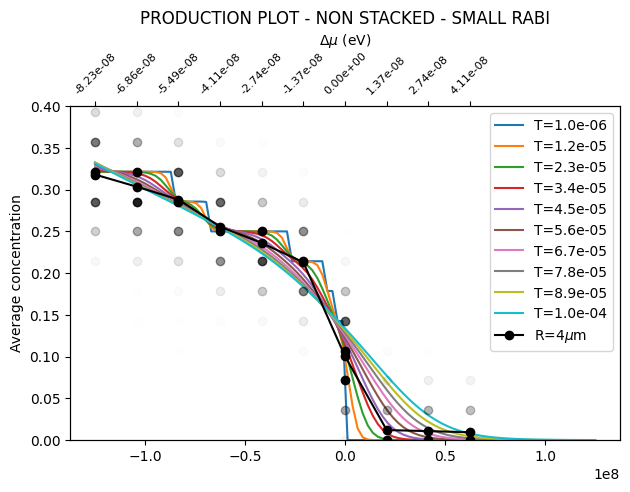

In [ ]:
fig, ax = plt.subplots()
# Hardware Δg values (positive strings)
# delta_g_all = ['125000000', '62500000', '31250000', '15625000', '0', '-31250000']
# delta_g_all_int_neg = [-int(x) for x in delta_g_all]  # Convert to negative integers

# === Load and plot Boltzmann data ===
with open("data/exhaustive_search/boltzmann_log/av_conc_4x3_4.01um_only.json", "r") as f:
    boltzmann_data = json.load(f)

for T_str, values in boltzmann_data.items():
    T = float(T_str)
    if T < 100:
        delta_mu = np.array(values["Delta_mu"]) * eV_to_rad_s
        avg_conc = np.array(values["avg_conc"])
        ax.plot(delta_mu, avg_conc, '-', label=f'T={T:.1e}')


# Folder containing data
folder = 'qpu_data/production/3x4/4micron_no_stacked/small_rabi'
delta_g_all_int_neg = -np.linspace(125000000, -62500000, 10)
# Load and process sequence data for each Δg
datasets = []
delta_g_all_int_neg_new = []
for delta_g in np.arange(10): 
    preseqs, postseqs = read_all_sequences_from_folder(os.path.join(folder, str(delta_g)))
    preseqs = stack_chunks_vertically(np.array(preseqs))
    postseqs = stack_chunks_vertically(np.array(postseqs))
    datasets.append((preseqs, postseqs, f"Δg = {delta_g}"))
    delta_g_all_int_neg_new.append(-extract_detuning_values(os.path.join(folder, str(delta_g)))[-1])

# Compute average Hamming distances
hamming_average_all = []
hamming_average_std = []
hamming_all = []
i = -1
for preseqs, postseqs, label in datasets:
    i += 1
    # _, hamming_avg, *_ = get_hamming(preseqs, postseqs)
    len_hamming, hamming_avg, hamming_std,hamming_max,hamming_min,hamming_unique, unique_index = get_hamming(preseqs, postseqs)
    hamming_average_all.append(hamming_avg)
    hamming_average_std.append(hamming_std)
    #TMP
    preseqs = np.array(preseqs)
    postseqs = np.array(postseqs)
    
    num_atoms = preseqs.shape[1]
    
    keep_config = np.where(np.sum(preseqs,axis=1) == num_atoms)[0]

    hamming_all_tmp = np.sum(postseqs[keep_config]==0,axis=1)
    hamming_unique, hamming_count = np.unique(hamming_all_tmp,return_counts=True)
    max_count = np.max(hamming_count)
    x = [delta_g_all_int_neg_new[i]]*len(hamming_count)
    
    for j,hu in enumerate(hamming_unique):
        # print(delta_g_all_int_neg_new[i],hu/28)
        ax.plot(delta_g_all_int_neg_new[i], hu/28, 'o', color='black', alpha=hamming_count[j] / max_count)
        # ax.plot(delta_g_all_int_neg_new[i], hu/28, 'o', color='black')

    

# Convert to numpy arrays for plotting
x_vals = np.array(delta_g_all_int_neg_new)
y_vals = np.array(hamming_average_all) / 28  # Normalize by sequence length
hamming_average_std = np.array(hamming_average_std)/28

# === Plotting: Hardware Data ===

ax.errorbar(
    x_vals, y_vals,
    # xerr=1e6,
    fmt='o-', capsize=4,
    label='R=4$\mu$m', color='k'
)

ax.set_ylabel('Average concentration')


ax.set_ylim([0,0.4])
# === Twin X-axis: μ axis in eV ===
ax_top = ax.twiny()
ax_top.set_xlim(ax.get_xlim())

# Convert hardware Δg to chemical potentials Δμ (in eV)
delta_mu_ticks = [(-reg_coef_rad_s[0] + dg * alpha_v) / eV_to_rad_s 
                  for dg in delta_g_all_int_neg]
ax_top.set_xticks(delta_g_all_int_neg)
ax_top.set_xticklabels([f"{mu:.2e}" for mu in delta_mu_ticks], fontsize=8, rotation=45)
ax_top.set_xlabel("$\\Delta\\mu$ (eV)")

ax.legend()
plt.tight_layout()
ax.set_title('PRODUCTION PLOT - NON STACKED - SMALL RABI')
plt.show()

In [ ]:
for i,j in enumerate(np.linspace(125000000, -62500000, 10)):
    print(i,j)

0 125000000.0
1 104166666.66666667
2 83333333.33333334
3 62500000.0
4 41666666.66666667
5 20833333.333333343
6 0.0
7 -20833333.333333313
8 -41666666.66666666
9 -62500000.0


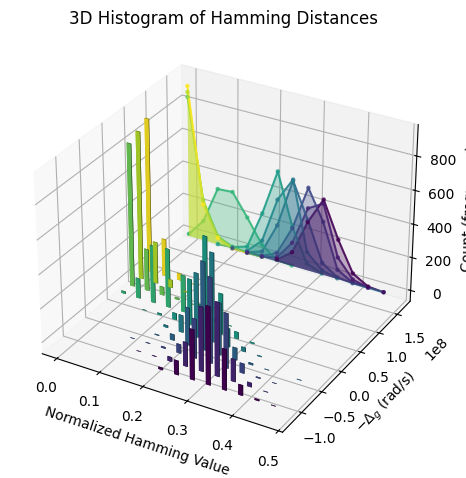

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import numpy as np
from collections import defaultdict

fig_3d = plt.figure()
ax3d = fig_3d.add_subplot(111, projection='3d')

xs = []  # hu/28
ys = []  # delta_g
zs = []  # hamming_count

# === Accumulate bar data ===
for i, (preseqs, postseqs, label) in enumerate(datasets):
    num_atoms = preseqs.shape[1]
    keep_config = np.where(np.sum(preseqs, axis=1) == num_atoms)[0]
    hamming_all_tmp = np.sum(postseqs[keep_config] == 0, axis=1)
    hamming_unique, hamming_count = np.unique(hamming_all_tmp, return_counts=True)

    for hu, count in zip(hamming_unique, hamming_count):
        xs.append(hu / 28)  # X: normalized Hamming value
        ys.append(delta_g_all_int_neg_new[i])  # Y: detuning
        zs.append(count)  # Z: height of the bar

# Convert to arrays
xs = np.array(xs)
ys = np.array(ys)
zs = np.array(zs)

# Set bar dimensions
dx = 0.01  # bar width in x
dy = 1e6   # bar width in y (adjust as needed)
dz = zs

# === Assign consistent colors per Δg value ===
unique_dgs = sorted(set(ys))
norm = Normalize(vmin=min(unique_dgs), vmax=max(unique_dgs))
cmap = cm.viridis
dg_to_color = {dg: cmap(norm(dg)) for dg in unique_dgs}

# === Plot bars grouped by Δg with consistent colors ===
for dg in unique_dgs:
    mask = ys == dg
    ax3d.bar3d(
        xs[mask], ys[mask], np.zeros_like(zs[mask]),
        dx, dy, zs[mask],
        color=dg_to_color[dg],
        shade=True
    )

# === Group data for back-panel projection ===
curves_by_dg = defaultdict(list)
for x, y, z in zip(xs, ys, zs):
    curves_by_dg[y].append((x, z))

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# === Plot projected curves and fill under them ===
y_back = min(ys) + 2.9e8  # Place at constant Y

for y_val, points in curves_by_dg.items():
    points = sorted(points, key=lambda p: p[0])
    x_curve = [p[0] for p in points]
    y_curve = [y_back] * len(points)
    z_curve = [p[1] for p in points]

    color = dg_to_color[y_val]

    # Plot the projected curve
    ax3d.plot(x_curve, y_curve, z_curve,
              color=color, lw=1.5, alpha=0.9)
    ax3d.scatter(x_curve, y_curve, z_curve,
                 color=color, s=5, alpha=0.7)

    # === Fill under the curve ===
    verts = [
        list(zip(x_curve, y_curve, z_curve)),
        list(zip(x_curve, y_curve, [0]*len(z_curve)))  # base (Z=0)
    ]
    # Connect top and bottom to form a closed polygon
    fill_poly = list(zip(x_curve, y_curve, z_curve)) + \
                list(zip(reversed(x_curve), reversed(y_curve), [0]*len(z_curve)))

    poly = Poly3DCollection([fill_poly], facecolors=color, alpha=0.3, linewidths=0)
    ax3d.add_collection3d(poly)

# === Labels and layout ===
ax3d.set_xlabel("Normalized Hamming Value")
ax3d.set_ylabel("$-\\Delta_g$ (rad/s)")
ax3d.set_zlabel("Count (frequency)")
ax3d.set_title("3D Histogram of Hamming Distances")

plt.tight_layout()
plt.show()

## Monte Carlo

#### New conc

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

def load_qpu_hamming_vs_detuning_simple(folder, detuning_indices, eV_to_rad_s, alpha_v, reg_coef):
    """
    For each detuning index in detuning_indices:
    - load QPU sequences for that index
    - keep only shots where all atoms are present in presequence
    - compute average + std of Hamming metric
    - record hardware detuning Δg (rad/s)

    Returns:
        x_qpu          : Δg in "eV units" (Δg / eV_to_rad_s)
        y_qpu          : mean concentration (Hamming / num_atoms)
        yerr_qpu       : std concentration
        delta_g_list   : raw Δg (rad/s)
    """

    delta_g_list = []
    hamming_avg_list = []
    hamming_std_list = []
    num_atoms_list = []

    for idx in detuning_indices:
        path = os.path.join(folder, str(idx))

        preseqs, postseqs = read_all_sequences_from_folder(path)
        preseqs = np.array(preseqs)
        postseqs = np.array(postseqs)

        if preseqs.ndim != 2 or postseqs.ndim != 2:
            raise RuntimeError(
                f"Expected 2D arrays from read_all_sequences_from_folder at detuning {idx}, "
                f"got shapes {preseqs.shape} and {postseqs.shape}"
            )
        if preseqs.shape[1] != postseqs.shape[1]:
            raise RuntimeError(
                f"Pre/Post mismatch in num atoms at detuning {idx}: "
                f"{preseqs.shape[1]} vs {postseqs.shape[1]}"
            )

        num_atoms = preseqs.shape[1]

        # keep only well-prepared shots (all atoms present)
        keep_mask = (np.sum(preseqs, axis=1) == num_atoms)
        preseqs_f = preseqs[keep_mask]
        postseqs_f = postseqs[keep_mask]

        if len(postseqs_f) == 0:
            continue

        # compute Hamming stats
        _, h_avg, h_std, *_ = get_hamming(preseqs_f, postseqs_f)
        hamming_avg_list.append(h_avg)
        hamming_std_list.append(h_std)
        num_atoms_list.append(num_atoms)

        # hardware Δg (rad/s) with your sign convention
        delta_g_hw = -extract_detuning_values(path)[-1]
        delta_g_list.append(delta_g_hw)

    if len(delta_g_list) == 0:
        raise RuntimeError("No valid shots in any detuning index for this folder.")

    delta_g_list = np.array(delta_g_list, dtype=float)
    hamming_avg_list = np.array(hamming_avg_list, dtype=float)
    hamming_std_list = np.array(hamming_std_list, dtype=float)
    num_atoms_list = np.array(num_atoms_list, dtype=int)

    # normalize Hamming by number of atoms
    y_qpu = hamming_avg_list / num_atoms_list
    yerr_qpu = hamming_std_list / num_atoms_list

    # x-values for plotting: Δg / eV_to_rad_s
    x_qpu = delta_g_list / eV_to_rad_s

    return x_qpu, y_qpu, yerr_qpu, delta_g_list


def plot_mc_vs_qpu(
    mc_path,
    qpu_folder,
    detuning_indices,
    eV_to_rad_s,
    alpha_v,
    reg_coef_rad_s,
):
    fig, ax = plt.subplots(figsize=(8, 7))

    # ---------- 1. QPU DATA ----------
    x_qpu, y_qpu, yerr_qpu, delta_g_hw_list = load_qpu_hamming_vs_detuning_simple(
        folder=qpu_folder,
        detuning_indices=detuning_indices,
        eV_to_rad_s=eV_to_rad_s,
        alpha_v=alpha_v,
        reg_coef=reg_coef_rad_s,
    )

    order = np.argsort(x_qpu)
    x_qpu = x_qpu[order]
    y_qpu = y_qpu[order]
    yerr_qpu = yerr_qpu[order]
    delta_g_hw_list = delta_g_hw_list[order]

    ax.plot(
        x_qpu,
        y_qpu,
        'o-',
        color='k',
        label='QPU',
        zorder=5,
    )

    # ---------- 2. MC CURVES ----------
    with open(mc_path, "r") as f:
        mc_data = json.load(f)

    sample_sizes = sorted(int(k) for k in mc_data.keys())

    for i, N in enumerate(sample_sizes):
        N_key = str(N)
        temp_groups = mc_data[N_key]
        temp_key = next(iter(temp_groups.keys()))
        values = temp_groups[temp_key]

        delta_mu_arr = np.array(values["Delta_mu"], dtype=float)   # eV
        avg_conc_arr = np.array(values["avg_conc"], dtype=float)

        # here the MC is already parameterised in Δμ, so x_mc = Δμ
        x_mc = delta_mu_arr

        sidx = np.argsort(x_mc)
        x_mc = x_mc[sidx]
        avg_conc_arr = avg_conc_arr[sidx]

        exponent = int(np.log10(N))
        ax.plot(
            x_mc,
            avg_conc_arr,
            marker='o',
            linestyle='-',
            label=rf"MC $N = 10^{{{exponent}}}$",
            zorder=3 - i,
        )

    # ---------- 3. Main axis styling ----------
    ax.set_ylabel(r"$\overline{[N]}$", fontsize=16)
    ax.set_ylim([0, 0.35])

    # main axis x-ticks: at QPU points (no labels here)
    ax.set_xticks(x_qpu)
    ax.set_xticklabels([])

    ax.tick_params(
        axis='both',
        which='both',
        direction='in',
        top=True,
        right=True,
        labelsize=14,
        length=6,
    )
    ax.grid(True, which='both', linewidth=0.5, alpha=0.4)

    # ---------- 4. TOP axis: Δg (eV) ----------
    ax_top = ax.twiny()
    ax_top.set_xlim(ax.get_xlim())
    ax_top.set_xticks(x_qpu)
    ax_top.set_xticklabels(
        [f"{val:.2e}" for val in x_qpu],
        rotation=45,
        ha='center'
    )
    ax_top.set_xlabel(r"-$\Delta_g$ (eV)", fontsize=16, labelpad=8)
    ax_top.tick_params(
        axis='x',
        which='both',
        direction='in',
        top=True,
        labelsize=14,
        length=6,
    )
    ax_top.grid(False)

    # ---------- 5. BOTTOM axis: Δμ (eV) ----------
    # Δμ = (-reg0 + α_v * Δg_hw) / eV_to_rad_s
    reg0 = reg_coef_rad_s[0]
    delta_mu_ticks = -reg0 + (alpha_v * delta_g_hw_list) / eV_to_rad_s
    print(-reg0, alpha_v,delta_g_hw_list,delta_mu_ticks )

    ax_bottom = ax.twiny()
    ax_bottom.set_xlim(ax.get_xlim())
    ax_bottom.set_xticks(x_qpu)
    ax_bottom.set_xticklabels(
        [f"{mu_val:.2e}" for mu_val in delta_mu_ticks],
        rotation=45,
        ha='center'
    )

    # move this axes to the bottom
    ax_bottom.spines["bottom"].set_position(("axes", 0))
    ax_bottom.xaxis.set_ticks_position("bottom")
    ax_bottom.xaxis.set_label_position("bottom")
    ax_bottom.spines["top"].set_visible(False)

    ax_bottom.set_xlabel(r"$\Delta\mu$ (eV)", fontsize=16, labelpad=10)
    ax_bottom.tick_params(
        axis='x',
        which='both',
        direction='out',
        bottom=True,
        top=False,
        labelsize=12,
        length=5,
        labelrotation=45,
    )
    ax_bottom.grid(False)

    # leave some room for the bottom axis
    plt.subplots_adjust(bottom=0.28)

    # ---------- 6. Legend ----------
    ax.legend(
        loc='best',
        fontsize=12,
        frameon=True,
        facecolor='white',
        edgecolor='0.4',
        framealpha=0.9,
    )

    plt.tight_layout()
    plt.show()

-0.0003613877583255407 236.72868078912074 [-1.25000000e+08 -1.04166667e+08 -8.33333334e+07 -6.25000000e+07
 -4.16666666e+07 -2.08333334e+07 -0.00000000e+00  2.08333334e+07
  4.16666666e+07  6.25000000e+07] [-0.00038086 -0.00037762 -0.00037437 -0.00037113 -0.00036788 -0.00036463
 -0.00036139 -0.00035814 -0.0003549  -0.00035165]


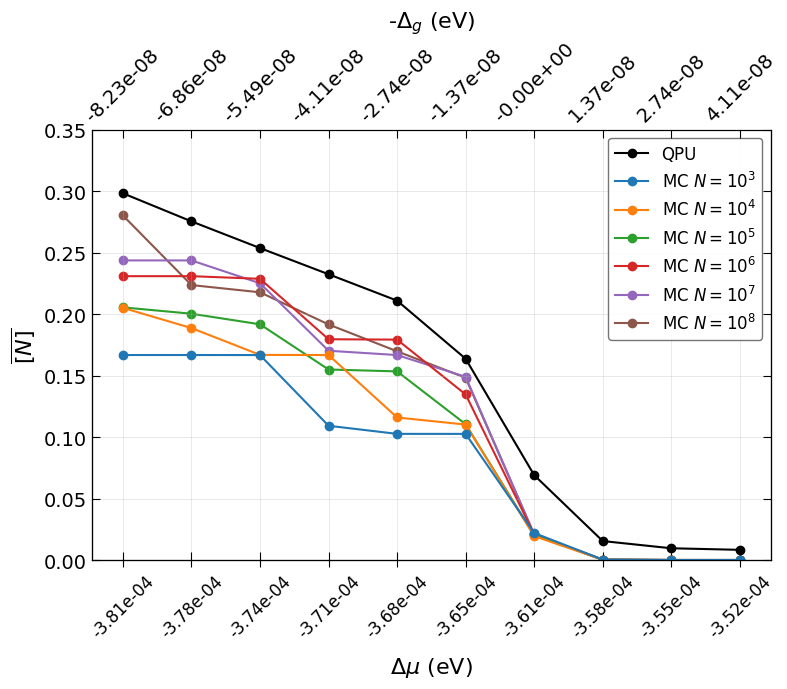

In [ ]:
# -------------------------
# USAGE EXAMPLE (you run this):
# -------------------------
plot_mc_vs_qpu(
    mc_path="/Users/brunocamino/Desktop/UCL/rydberg_atoms/data/Monte_carlo/production/mc_av_conc_by_samplesize_new_conc.json",
    qpu_folder="qpu_data/production/6x6/4micron",
    detuning_indices=[0,1,2,3,4,5,6,7,8,9],
    eV_to_rad_s=eV_to_rad_s,
    alpha_v=alpha_v,
    reg_coef_rad_s=reg_coef,
)

### Histogram

In [16]:
import os
import numpy as np
import json

def compute_qpu_state_energies_for_mu(
    qpu_folder: str,
    detuning_index: int,
    coordinates: np.ndarray,
    read_all_sequences_from_folder,
    stack_chunks_vertically,
    extract_detuning_values,
    *,
    C6_rad_m6_per_s: float = 5.42e-24,
    EV_TO_RAD_S: float = 1.519267447321156e15,
    reg_coef_rad_s0: float = 0.0,
    alpha_v: float = 1.0,
    bit_value_is_occupied: int = 0,
    save_csv_path: str | None = None,
    return_interaction_matrix: bool = False,
):
    """
    Compute energies for the QPU-observed states at a single detuning index.

    Parameters
    ----------
    qpu_folder : str
        Root folder containing subfolders "0", "1", ... for each detuning.
    detuning_index : int
        Which subfolder to read (e.g., 0 for the first detuning).
    coordinates : (N,3) np.ndarray
        Atom coordinates in meters (your 28 positions).
    read_all_sequences_from_folder : callable
        Function(path) -> (preseqs, postseqs). Arrays/lists of shape (shots, N).
    stack_chunks_vertically : callable
        Function(array_like) -> np.ndarray stacked into a single (shots, N) array.
    extract_detuning_values : callable
        Function(path) -> sequence of detuning values (Δg in rad/s); we use the last element and negate.
    C6_rad_m6_per_s : float
        C6 coefficient in rad·m^6/s.
    EV_TO_RAD_S : float
        Conversion factor eV -> rad/s.
    reg_coef_rad_s0 : float
        Regression intercept (rad/s) used in Δμ = (-reg0 + Δg * alpha_v) / EV_TO_RAD_S.
    alpha_v : float
        Regression slope that maps hardware Δg to the model (unitless or scaling factor).
    bit_value_is_occupied : int
        Treat this bit value in the QPU shot as 'occupied' (1 in x). Default=0 to match your convention.
    save_csv_path : str or None
        If provided, writes a CSV with per-shot energies/metadata.
    return_interaction_matrix : bool
        If True, also returns the (N,N) interaction matrix V (in eV).

    Returns
    -------
    df : pandas.DataFrame
        Columns: shot_index, conc, energy_eV, energy_plus_mu_eV, delta_g_rad_per_s, delta_mu_eV, bitstring
        bitstring preserves the raw postsequence (0/1 per site).
    meta : dict
        Small metadata dict with detuning, counts, etc.
    V_eV : np.ndarray (optional)
        Only if return_interaction_matrix=True.
    """
    import pandas as pd
    from scipy.spatial import distance_matrix

    # ---------- Build interaction matrix V (eV) ----------
    coords = np.asarray(coordinates, dtype=float)
    if coords.ndim != 2 or coords.shape[1] != 3:
        raise ValueError("coordinates must be shape (N, 3) in meters")

    dm = distance_matrix(coords, coords)
    # Avoid division by zero on diagonal during inv^6; then zero it out after scaling
    np.fill_diagonal(dm, 1.0)
    inv6 = (1.0 / dm) ** 6
    V_eV = (C6_rad_m6_per_s * inv6) / EV_TO_RAD_S
    np.fill_diagonal(V_eV, 0.0)
    N = V_eV.shape[0]

    # ---------- Load QPU data for this detuning index ----------
    sub = os.path.join(qpu_folder, str(detuning_index))
    preseqs, postseqs = read_all_sequences_from_folder(sub)
    preseqs = stack_chunks_vertically(np.array(preseqs))
    postseqs = stack_chunks_vertically(np.array(postseqs))

    if postseqs.shape[1] != N:
        raise ValueError(f"Shot width ({postseqs.shape[1]}) != number of coordinates ({N}).")

    # Keep only prepared shots: all atoms present in preseqs
    keep = np.where(np.sum(preseqs, axis=1) == N)[0]
    shots = postseqs[keep]  # shape (B, N)
    B = shots.shape[0]
    if B == 0:
        raise RuntimeError("No valid shots after preparation filter (all-atoms-present).")

    # Hardware Δg for this subfolder (use last value, negate to match your prior code)
    delta_g_rad_s = -extract_detuning_values(sub)[-1]

    # Chemical potential for this detuning
    delta_mu_eV = delta_g_rad_s/eV_to_rad_s#(-float(reg_coef_rad_s0) + float(delta_g_rad_s) * float(alpha_v)) / float(EV_TO_RAD_S)

    # ---------- Convert to occupations & compute energies ----------
    # Your convention: '0' in the shot is occupied (x_i = 1)
    X = (shots == int(bit_value_is_occupied)).astype(np.float64)     # (B, N)
    conc = X.sum(axis=1).astype(int)                                 # (B,)

    # Classical pair energy: 0.5 * x^T V x per shot
    E_classical = 0.5 * np.einsum('bi,ij,bj->b', X, V_eV, X)         # (B,)

    # Add μ term: E(μ) = E_classical + conc * Δμ
    E_mu = E_classical + conc * delta_mu_eV

    # ---------- Package results ----------
    bitstrings = ["".join(str(int(b)) for b in row.tolist()) for row in shots]
    df = pd.DataFrame({
        "shot_index": np.arange(B, dtype=int),
        "conc": conc,
        "energy_eV": E_classical,
        "energy_plus_mu_eV": E_mu,
        "delta_g_rad_per_s": delta_g_rad_s,
        "delta_mu_eV": delta_mu_eV,
        "bitstring": bitstrings,
    })

    meta = {
        "detuning_index": int(detuning_index),
        "num_shots": int(B),
        "num_atoms": int(N),
        "delta_g_rad_per_s": float(delta_g_rad_s),
        "delta_mu_eV": float(delta_mu_eV),
        "bit_convention": f"{bit_value_is_occupied} => occupied",
        "notes": "Energies of QPU-observed states; classical pair energy plus μ·N_occ."
    }

    if save_csv_path is not None:
        df.to_csv(save_csv_path, index=False)

    return (df, meta, V_eV) if return_interaction_matrix else (df, meta)

In [17]:
# 2) Your 28 coordinates array (meters) – use the one you posted
coordinates = np.array([
    [0.000000, 0.000000],
    [-2.005000, 3.472762],
    [0.000000, 6.945524],
    [-2.005000, 10.418286],
    [0.000000, 13.891047],
    [-2.005000, 17.363809],
    [0.000000, 20.836571],
    [-2.005000, 24.309333],
    [0.000000, 27.782095],
    [-2.005000, 31.254857],
    [0.000000, 34.727619],
    [-2.005000, 38.200381],
    [0.000000, 41.673142],
    [4.010000, 0.000000],
    [6.015000, 3.472762],
    [4.010000, 6.945524],
    [6.015000, 10.418286],
    [4.010000, 13.891047],
    [6.015000, 17.363809],
    [4.010000, 20.836571],
    [6.015000, 24.309333],
    [4.010000, 27.782095],
    [6.015000, 31.254857],
    [4.010000, 34.727619],
    [6.015000, 38.200381],
    [4.010000, 41.673142],
    [12.030000, 0.000000],
    [10.025000, 3.472762],
    [12.030000, 6.945524],
    [10.025000, 10.418286],
    [12.030000, 13.891047],
    [10.025000, 17.363809],
    [12.030000, 20.836571],
    [10.025000, 24.309333],
    [12.030000, 27.782095],
    [10.025000, 31.254857],
    [12.030000, 34.727619],
    [10.025000, 38.200381],
    [12.030000, 41.673142],
    [16.040000, 0.000000],
    [18.045000, 3.472762],
    [16.040000, 6.945524],
    [18.045000, 10.418286],
    [16.040000, 13.891047],
    [18.045000, 17.363809],
    [16.040000, 20.836571],
    [18.045000, 24.309333],
    [16.040000, 27.782095],
    [18.045000, 31.254857],
    [16.040000, 34.727619],
    [18.045000, 38.200381],
    [16.040000, 41.673142],
    [24.060000, 0.000000],
    [22.055000, 3.472762],
    [24.060000, 6.945524],
    [22.055000, 10.418286],
    [24.060000, 13.891047],
    [22.055000, 17.363809],
    [24.060000, 20.836571],
    [22.055000, 24.309333],
    [24.060000, 27.782095],
    [22.055000, 31.254857],
    [24.060000, 34.727619],
    [22.055000, 38.200381],
    [24.060000, 41.673142],
    [28.070000, 0.000000],
    [30.075000, 3.472762],
    [28.070000, 6.945524],
    [30.075000, 10.418286],
    [28.070000, 13.891047],
    [30.075000, 17.363809],
    [28.070000, 20.836571],
    [30.075000, 24.309333],
    [28.070000, 27.782095],
    [30.075000, 31.254857],
    [28.070000, 34.727619],
    [30.075000, 38.200381],
    [28.070000, 41.673142],
])

coordinates = np.hstack([coordinates, np.zeros((coordinates.shape[0], 1))])
coordinates = coordinates*1e-6
identity_stack = lambda a: np.asarray(a)  # leaves a 2D array unchanged

# 3) Call the function for one detuning
df_qpu, meta = compute_qpu_state_energies_for_mu(
    qpu_folder='qpu_data/production/6x6/4micron',
    detuning_index=6,                     # <- pick the one you want
    coordinates=coordinates,
    read_all_sequences_from_folder=read_all_sequences_from_folder,
    stack_chunks_vertically=identity_stack,
    extract_detuning_values=extract_detuning_values,
    C6_rad_m6_per_s=5.42e-24,
    EV_TO_RAD_S=1.519267447321156e15,
    reg_coef_rad_s0=reg_coef_rad_s[0],   # if you have this defined in the notebook
    alpha_v=alpha_v,                      # "
    bit_value_is_occupied=0,             # keep your convention
    save_csv_path="qpu_states_energy_mu_idx0.csv"
)

df_qpu.head(), meta

(   shot_index  conc     energy_eV  energy_plus_mu_eV  delta_g_rad_per_s  \
 0           0     5  1.576636e-09       1.576636e-09               -0.0   
 1           1     8  3.715059e-08       3.715059e-08               -0.0   
 2           2     5  5.636081e-10       5.636081e-10               -0.0   
 3           3     4  5.649928e-10       5.649928e-10               -0.0   
 4           4     9  9.932242e-08       9.932242e-08               -0.0   
 
    delta_mu_eV                                          bitstring  
 0         -0.0  0111111011110111111111111111111111111111111111...  
 1         -0.0  1110110111110111111111111111101111111111111111...  
 2         -0.0  1111011111110111111111111111111111101111111111...  
 3         -0.0  1111101111011111111111111111111111111111101111...  
 4         -0.0  1011011111011111111010111111111111101111111111...  ,
 {'detuning_index': 6,
  'num_shots': 487,
  'num_atoms': 78,
  'delta_g_rad_per_s': -0.0,
  'delta_mu_eV': -0.0,
  'bit_conven

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_classical_binned_vs_qpu_dual_axis_pretty_zoom(
    classical_csv,
    df_qpu,
    use_energy_with_mu=True,
    normalize=True,
    shift_fraction=0.25,      # slight x-shift of QPU bars
    xmax_fixed=None,          # if None, we'll use quantiles instead
    clip_qpu_ylim=True,       # zoom left y-axis so we can see structure
    p_low=1e-3,               # lower CDF quantile for x-zoom
    p_high=0.999,             # upper CDF quantile for x-zoom
):
    """
    Overlay of QPU vs Classical energy distributions with twin y-axes.

    NEW compared to your original:
      - Instead of always plotting full [min, max] (or hard xmax),
        we zoom the x-axis to the region where the classical distribution
        has CDF in [p_low, p_high] (e.g. central 99.8%), plus a bit of padding.
    """

    # --- Load classical binned data ---
    df_class = pd.read_csv(classical_csv)
    left_edges_raw  = df_class["edge_left_eV"].to_numpy(dtype=float)
    right_edges_raw = df_class["edge_right_eV"].to_numpy(dtype=float)
    class_counts_raw = df_class["count"].to_numpy(dtype=float)

    class_bin_centers_raw = 0.5 * (left_edges_raw + right_edges_raw)

    # --- Pick QPU energy column ---
    if use_energy_with_mu:
        if "energy_plus_mu_eV" not in df_qpu.columns:
            raise KeyError("df_qpu must contain 'energy_plus_mu_eV' when use_energy_with_mu=True")
        qpu_energy = df_qpu["energy_plus_mu_eV"].to_numpy(dtype=float)
        x_label = r"$E + N\mu$ (eV)"
    else:
        if "energy_eV" not in df_qpu.columns:
            raise KeyError("df_qpu must contain 'energy_eV' when use_energy_with_mu=False")
        qpu_energy = df_qpu["energy_eV"].to_numpy(dtype=float)
        x_label = r"$E$ (eV)"

    # --- Build common bin edges across BOTH datasets ---
    n_class_bins = len(class_counts_raw)

    global_xmin = min(qpu_energy.min(), left_edges_raw.min())
    global_xmax = max(qpu_energy.max(), right_edges_raw.max())

    common_edges = np.linspace(global_xmin, global_xmax, n_class_bins + 1)
    common_centers = 0.5 * (common_edges[:-1] + common_edges[1:])
    common_widths  = (common_edges[1:] - common_edges[:-1])

    # --- Re-bin classical into those common edges using weighted histogram ---
    classical_hist_counts, _ = np.histogram(
        class_bin_centers_raw,
        bins=common_edges,
        weights=class_counts_raw
    )

    # --- Histogram QPU into same edges ---
    qpu_hist_counts, _ = np.histogram(qpu_energy, bins=common_edges)

    # --- Normalize (prob distributions) ---
    if normalize:
        classical_total = classical_hist_counts.sum()
        qpu_total = qpu_hist_counts.sum()

        classical_prob = (
            classical_hist_counts / classical_total if classical_total > 0
            else classical_hist_counts.astype(float)
        )
        qpu_prob = (
            qpu_hist_counts / qpu_total if qpu_total > 0
            else qpu_hist_counts.astype(float)
        )
    else:
        classical_prob = classical_hist_counts.astype(float)
        qpu_prob = qpu_hist_counts.astype(float)

    # --- Slight x-shift for QPU bars to declutter ---
    avg_bin_width = np.mean(common_widths) if len(common_widths) else 0.0
    qpu_shift = avg_bin_width * shift_fraction
    qpu_centers_shifted = common_centers - qpu_shift

    # =====================================================
    # AUTO-ZOOM REGION IN X USING CLASSICAL CDF
    # =====================================================
    if xmax_fixed is None:
        # Use classical PMF to define a central window in energy
        cdf = np.cumsum(classical_prob)
        # Indices where CDF crosses p_low and p_high
        i_low = np.searchsorted(cdf, p_low)
        i_high = np.searchsorted(cdf, p_high)

        i_low = max(0, min(i_low, len(common_centers)-1))
        i_high = max(0, min(i_high, len(common_centers)-1))

        x_low = common_centers[i_low]
        x_high = common_centers[i_high]

        # add a bit of padding around that window
        span = x_high - x_low if x_high > x_low else (global_xmax - global_xmin)
        pad = 0.1 * span
        xmin_plot = x_low - pad
        xmax_plot = x_high + pad
        print(f"Auto zoom: CDF [{p_low}, {p_high}] -> x in [{x_low:.3e}, {x_high:.3e}]")
    else:
        # Use user-provided xmax_fixed with a little padding on the left
        span = global_xmax - global_xmin
        pad = 0.05 * span
        xmin_plot = global_xmin - pad
        xmax_plot = xmax_fixed

    # =====================================================
    # Plot
    # =====================================================
    fig, ax_left = plt.subplots(figsize=(9, 4.8))
    ax_right = ax_left.twinx()

    # --- 1. Classical line FIRST (blue, right axis) ---
    ax_right.plot(
        common_centers,
        classical_prob,
        color='tab:blue',
        linewidth=2.2,
        alpha=0.9,
        label='Classical (ES)',
        zorder=5,
    )

    # --- 2. QPU bars AFTER (orange, left axis) ---
    ax_left.bar(
        qpu_centers_shifted,
        qpu_prob,
        width=common_widths * 0.8,   # a bit narrower than full bin for clarity
        align='center',
        color='#E69F00',
        edgecolor='#E69F00',
        alpha=0.8,
        linewidth=0.9,
        label="QPU",
        zorder=3,
    )

    # =====================================================
    # Axis labels / ticks / limits
    # =====================================================
    ax_left.set_xlabel(x_label, fontsize=16)
    ax_left.set_ylabel("QPU probability", fontsize=16, color='#E69F00', labelpad=5)
    ax_right.set_ylabel("Classical probability", fontsize=16, color='tab:blue', labelpad=8)

    # color y tick labels to match axis color
    ax_left.tick_params(axis='y', colors='#E69F00')
    ax_right.tick_params(axis='y', colors='tab:blue')

    # Match your house style
    for ax in (ax_left, ax_right):
        ax.tick_params(
            axis='both',
            which='both',
            direction='in',
            top=True,
            right=True,
            labelsize=12,
            length=6,
        )
        ax.grid(True, which='both', linewidth=0.5, alpha=0.4)

    # --- X limits: use zoomed window we computed above ---
    ax_left.set_xlim(xmin_plot, xmax_plot)

    # --- Optional: clip left y-axis so spike doesn't flatten everything ---
    if clip_qpu_ylim:
        if len(qpu_prob) > 0:
            nonzero_probs = qpu_prob[qpu_prob > 0]
            if len(nonzero_probs) > 10:
                qpu_ymax = np.quantile(nonzero_probs, 0.995) * 1.1  # 99.5th percentile + pad
            else:
                qpu_ymax = np.max(qpu_prob) * 1.05
        else:
            qpu_ymax = 1.0
        ax_left.set_ylim(0, qpu_ymax)
        print(f"Left y-axis limited to ~99.5th percentile: {qpu_ymax:.3e}")
    else:
        ax_left.set_ylim(0, np.max(qpu_prob) * 1.05)

    # =====================================================
    # Legend (single combined box)
    # =====================================================
    handles = [
        plt.Line2D([], [], color='#E69F00', lw=3.0, label='QPU'),
        plt.Line2D([], [], color='tab:blue', lw=2.2, label='Classical (ES)'),
    ]
    ax_left.legend(
        handles=handles,
        loc='upper right',
        fontsize=12,
        frameon=True,
        facecolor='white',
        edgecolor='0.4',
        framealpha=0.9,
    )

    # Debug prints to keep an eye on ranges
    print("QPU energy min/max:", qpu_energy.min(), qpu_energy.max())
    print("Classical edges min/max:", left_edges_raw.min(), right_edges_raw.max())
    print("Plotted xlim:", xmin_plot, xmax_plot)

    plt.tight_layout()
    plt.show()

Auto zoom: CDF [0.001, 0.8] -> x in [5.000e-09, 6.156e-05]
Left y-axis limited to ~99.5th percentile: 6.281e-01
QPU energy min/max: 0.0 2.9689971373727046e-06
Classical edges min/max: 0.0 9.616e-05
Plotted xlim: -6.151e-06 6.7721e-05


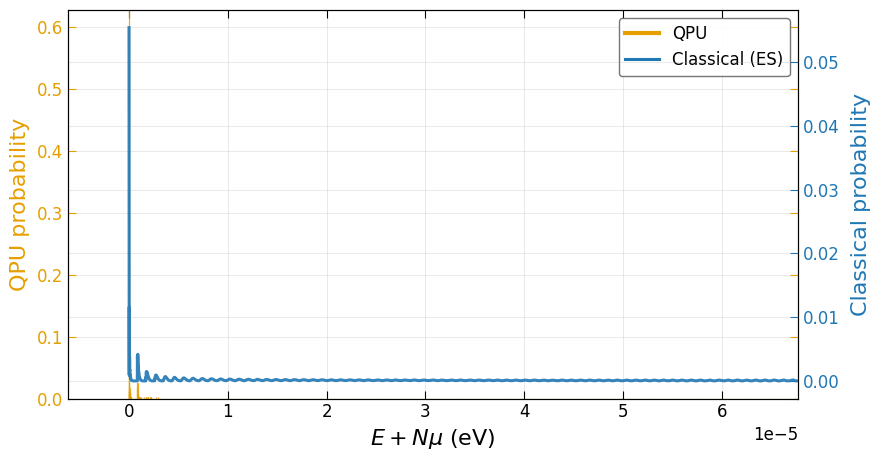

In [ ]:
plot_classical_binned_vs_qpu_dual_axis_pretty_zoom(
    classical_csv="data/Monte_carlo/production/num_states_vs_energy__mu=0.csv",
    df_qpu=df_qpu,                 # from compute_qpu_state_energies_for_mu
    use_energy_with_mu=True,
    p_low=1e-3,       # tweak these if you want tighter/looser zoom
    p_high=0.80,
)

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401


def plot_classical_vs_qpu_3d_columns(
    classical_csv,
    df_qpu,
    use_energy_with_mu=True,
    normalize=True,
    xmax_fixed=None,
    p_low=1e-3,
    p_high=0.999,
    zmax=0.05,
    column_scale=0.8,      # relative base size in x
    rebin_factor=3,        # how many neighbouring bins to merge (>=1)
    min_frac_of_max=0.01,  # drop bars below this fraction of each dataset's max
):
    """
    3D column plot of QPU vs Classical distributions.

    - Rebins along energy for fatter, fewer columns.
    - Drops very small probabilities to reduce clutter.
    - Uses one shared vertical axis and square bases.
    """

    # ---------- Load classical ----------
    df_class = pd.read_csv(classical_csv)
    left_edges_raw  = df_class["edge_left_eV"].to_numpy(float)
    right_edges_raw = df_class["edge_right_eV"].to_numpy(float)
    class_counts_raw = df_class["count"].to_numpy(float)
    centers_raw = 0.5 * (left_edges_raw + right_edges_raw)

    # ---------- Load QPU ----------
    if use_energy_with_mu:
        energy_col = "energy_plus_mu_eV"
        if energy_col not in df_qpu.columns:
            raise KeyError(f"df_qpu missing '{energy_col}'")
        x_label = r"$E + N\mu$ (eV)"
    else:
        energy_col = "energy_eV"
        if energy_col not in df_qpu.columns:
            raise KeyError(f"df_qpu missing '{energy_col}'")
        x_label = r"$E$ (eV)"

    qpu_energy = df_qpu[energy_col].to_numpy(float)

    # ---------- Make common bins ----------
    N_bins = len(class_counts_raw)
    xmin = min(qpu_energy.min(), left_edges_raw.min())
    xmax = max(qpu_energy.max(), right_edges_raw.max())

    edges = np.linspace(xmin, xmax, N_bins + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])
    bin_width = edges[1] - edges[0]
    base_width = bin_width * column_scale  # scalar

    # ---------- Histogram ----------
    class_hist, _ = np.histogram(centers_raw, bins=edges, weights=class_counts_raw)
    qpu_hist,   _ = np.histogram(qpu_energy,   bins=edges)

    # ---------- Normalize ----------
    if normalize:
        class_prob = class_hist / class_hist.sum() if class_hist.sum() > 0 else class_hist.astype(float)
        qpu_prob   = qpu_hist   / qpu_hist.sum()   if qpu_hist.sum()   > 0 else qpu_hist.astype(float)
    else:
        class_prob = class_hist.astype(float)
        qpu_prob   = qpu_hist.astype(float)

    # ---------- Auto zoom using classical CDF ----------
    cdf = np.cumsum(class_prob)
    i_low  = max(0, min(np.searchsorted(cdf, p_low),  N_bins - 1))
    i_high = max(0, min(np.searchsorted(cdf, p_high), N_bins - 1))

    x_low  = centers[i_low]
    x_high = centers[i_high]
    span = max(1e-15, x_high - x_low)
    pad = 0.1 * span
    xmin_zoom = x_low - pad
    xmax_zoom = x_high + pad

    # restrict to zoom window
    zoom_mask = (centers >= xmin_zoom) & (centers <= xmax_zoom)
    centers_z  = centers[zoom_mask]
    class_prob_z = class_prob[zoom_mask]
    qpu_prob_z   = qpu_prob[zoom_mask]

    # ---------- Rebin for thicker columns ----------
    def rebin_1d(x_vals, y_vals, n):
        if n <= 1:
            return x_vals, y_vals
        L = len(x_vals)
        # truncate tail so it's divisible by n
        L_trunc = (L // n) * n
        x_vals = x_vals[:L_trunc]
        y_vals = y_vals[:L_trunc]
        x_new = x_vals.reshape(-1, n).mean(axis=1)     # center of merged bins
        y_new = y_vals.reshape(-1, n).sum(axis=1)      # sum probs in window
        return x_new, y_new

    xz, class_prob_rb = rebin_1d(centers_z, class_prob_z, rebin_factor)
    _,  qpu_prob_rb   = rebin_1d(centers_z, qpu_prob_z,   rebin_factor)

    # ---------- Drop tiny bars ----------
    max_class = class_prob_rb.max() if len(class_prob_rb) else 0.0
    max_qpu   = qpu_prob_rb.max()   if len(qpu_prob_rb)   else 0.0

    class_prob_rb[class_prob_rb < min_frac_of_max * max_class] = 0.0
    qpu_prob_rb[qpu_prob_rb < min_frac_of_max * max_qpu]       = 0.0

    # ---------- Build figure ----------
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111, projection='3d')

    qpu_color = "#E69F00"
    es_color  = "tab:blue"

    # positions along the y-axis (front/back separation)
    y_qpu = 0.0
    y_es  = 1.2

    # ---------- Plot QPU columns ----------
    for x, height in zip(xz, qpu_prob_rb):
        if height <= 0:
            continue
        ax.bar3d(
            x, y_qpu, 0,
            base_width, base_width, height,
            color=qpu_color,
            alpha=0.9,
            shade=True,
            edgecolor="k",
            linewidth=0.3,
        )

    # ---------- Plot Classical columns ----------
    for x, height in zip(xz, class_prob_rb):
        if height <= 0:
            continue
        ax.bar3d(
            x, y_es, 0,
            base_width, base_width, height,
            color=es_color,
            alpha=0.85,
            shade=True,
            edgecolor="k",
            linewidth=0.3,
        )

    # ---------- Axis labels / limits ----------
    ax.set_xlabel(x_label, fontsize=14, labelpad=10)
    ax.set_ylabel("Dataset", fontsize=14, labelpad=10)
    ax.set_zlabel("Probability", fontsize=14, labelpad=10)

    ax.set_xlim(xmin_zoom, xmax_zoom)
    ax.set_ylim(-0.5, 1.7)
    ax.set_zlim(0, zmax)

    ax.set_yticks([y_qpu, y_es])
    ax.set_yticklabels(["QPU", "Classical (ES)"])

    # Wider box in x than in y/z so columns are not squashed
    ax.set_box_aspect((2.0, 1.0, 0.7))

    # nice viewing angle
    ax.view_init(elev=25, azim=-135)

    # light grid
    for axis in ["x", "y", "z"]:
        ax.__dict__[f"{axis}axis"]._axinfo["grid"]["linestyle"] = ":"
        ax.__dict__[f"{axis}axis"]._axinfo["grid"]["alpha"] = 0.3

    # legend
    fig.legend(
        ["QPU", "Classical (ES)"],
        loc="upper right",
        fontsize=12,
        frameon=True,
        framealpha=0.9,
    )

    plt.tight_layout()
    plt.show()

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_classical_binned_vs_qpu_dual_axis_pretty(
    classical_csv,
    df_qpu,
    use_energy_with_mu=True,
    normalize=True,
    shift_fraction=0.25,
    xmax_fixed=2.5e-5,
    clip_qpu_ylim=True,
    clip_class_ylim=True,
    zoom_to_mass=0.99,      # show the region containing 99% of classical prob
    mu_value=None,
):
    # --- Load classical binned data ---
    df_class = pd.read_csv(classical_csv)
    left_edges_raw  = df_class["edge_left_eV"].to_numpy(float)
    right_edges_raw = df_class["edge_right_eV"].to_numpy(float)
    class_counts_raw = df_class["count"].to_numpy(float)

    class_bin_centers_raw = 0.5 * (left_edges_raw + right_edges_raw)

    # --- Pick QPU energy column ---
    if use_energy_with_mu:
        if "energy_plus_mu_eV" not in df_qpu.columns:
            raise KeyError("df_qpu must contain 'energy_plus_mu_eV' when use_energy_with_mu=True")
        qpu_energy = df_qpu["energy_plus_mu_eV"].to_numpy(float)
        x_label = r"$E + N\mu$ (eV)"
    else:
        if "energy_eV" not in df_qpu.columns:
            raise KeyError("df_qpu must contain 'energy_eV' when use_energy_with_mu=False")
        qpu_energy = df_qpu["energy_eV"].to_numpy(float)
        x_label = r"$E$ (eV)"

    # --- Common bins ---
    n_class_bins = len(class_counts_raw)
    global_xmin = min(qpu_energy.min(), left_edges_raw.min())
    global_xmax = max(qpu_energy.max(), right_edges_raw.max())

    common_edges   = np.linspace(global_xmin, global_xmax, n_class_bins + 1)
    common_centers = 0.5 * (common_edges[:-1] + common_edges[1:])
    common_widths  = (common_edges[1:] - common_edges[:-1])

    # --- Re-bin classical & QPU ---
    classical_hist_counts, _ = np.histogram(
        class_bin_centers_raw, bins=common_edges, weights=class_counts_raw
    )
    qpu_hist_counts, _ = np.histogram(qpu_energy, bins=common_edges)

    # --- Normalize ---
    if normalize:
        classical_total = classical_hist_counts.sum()
        qpu_total = qpu_hist_counts.sum()
        classical_prob = classical_hist_counts / classical_total if classical_total > 0 else classical_hist_counts.astype(float)
        qpu_prob       = qpu_hist_counts       / qpu_total       if qpu_total       > 0 else qpu_hist_counts.astype(float)
    else:
        classical_prob = classical_hist_counts.astype(float)
        qpu_prob       = qpu_hist_counts.astype(float)

    # --- Zoom x-range to where most classical mass is ---
    if zoom_to_mass is not None and 0 < zoom_to_mass < 1 and classical_prob.sum() > 0:
        # sort by energy
        idx = np.argsort(common_centers)
        x_sorted = common_centers[idx]
        p_sorted = classical_prob[idx]
        cdf = np.cumsum(p_sorted)
        lo = x_sorted[np.searchsorted(cdf, (1 - zoom_to_mass) / 2)]
        hi = x_sorted[np.searchsorted(cdf, 1 - (1 - zoom_to_mass) / 2)]
        xmin_zoom, xmax_zoom = lo, hi
    else:
        xmin_zoom, xmax_zoom = global_xmin, global_xmax

    # --- Positions & widths for bars ---
    avg_bin_width = np.mean(common_widths) if len(common_widths) else 0.0
    half_shift = avg_bin_width * shift_fraction * 0.5
    qpu_centers_shifted = common_centers - half_shift
    cls_centers_shifted = common_centers + half_shift
    bar_width = avg_bin_width * (1.0 - shift_fraction)

    # --- Figure / axes ---
    fig, ax_left = plt.subplots(figsize=(9, 4.8))
    ax_right = ax_left.twinx()

    # For readability, only draw bars where prob > 0
    mask_qpu = qpu_prob > 0
    mask_cls = classical_prob > 0

    # Classical bars (blue, right axis)
    ax_right.bar(
        cls_centers_shifted[mask_cls],
        classical_prob[mask_cls],
        width=bar_width,
        align='center',
        color='tab:blue',
        edgecolor='tab:blue',
        alpha=0.7,
        label='Classical (ES)',
        zorder=2,
    )

    # QPU bars (orange, left axis)
    ax_left.bar(
        qpu_centers_shifted[mask_qpu],
        qpu_prob[mask_qpu],
        width=bar_width,
        align='center',
        color='#E69F00',
        edgecolor='#E69F00',
        alpha=0.8,
        label='QPU',
        zorder=3,
    )

    # --- Labels / ticks ---
    ax_left.set_xlabel(x_label, fontsize=16)
    ax_left.set_ylabel("QPU probability", fontsize=16, color='#E69F00', labelpad=5)
    ax_right.set_ylabel("Classical probability", fontsize=16, color='tab:blue', labelpad=8)

    ax_left.tick_params(axis='y', colors='#E69F00')
    ax_right.tick_params(axis='y', colors='tab:blue')

    for ax in (ax_left, ax_right):
        ax.tick_params(axis='both', which='both', direction='in',
                       top=True, right=True, labelsize=12, length=6)
        ax.grid(True, which='both', linewidth=0.5, alpha=0.4)

    # --- X limits: zoomed + small padding ---
    span = xmax_zoom - xmin_zoom
    pad = 0.05 * span
    ax_left.set_xlim(xmin_zoom - pad, min(xmax_fixed, xmax_zoom + pad))

    # --- Clip y-limits on both axes using percentiles ---
    if clip_qpu_ylim and mask_qpu.any():
        nz = qpu_prob[mask_qpu]
        if len(nz) > 10:
            ymax_qpu = np.quantile(nz, 0.995) * 1.1
        else:
            ymax_qpu = nz.max() * 1.05
        ax_left.set_ylim(0, ymax_qpu)

    if clip_class_ylim and mask_cls.any():
        nz_c = classical_prob[mask_cls]
        if len(nz_c) > 10:
            ymax_class = np.quantile(nz_c, 0.995) * 1.1
        else:
            ymax_class = nz_c.max() * 1.05
        ax_right.set_ylim(0, ymax_class)

    # --- Δμ textbox, if requested ---
    if mu_value is not None:
        mu_val = float(mu_value)
        ax_left.text(
            0.65, 0.50,
            rf"$\Delta\mu = {mu_val:.2e}\ \mathrm{{eV}}$",
            transform=ax_left.transAxes,
            fontsize=14,
            va='top',
            bbox=dict(facecolor='white', edgecolor='black', alpha=0.8, pad=6),
        )

    # --- Legend ---
    handles = [
        plt.Line2D([], [], color='#E69F00', lw=4.0, label='QPU'),
        plt.Line2D([], [], color='tab:blue', lw=4.0, label='Classical (ES)'),
    ]
    ax_left.legend(handles=handles, loc='upper right', fontsize=12,
                   frameon=True, facecolor='white', edgecolor='0.4', framealpha=0.9)

    plt.tight_layout()
    plt.show()

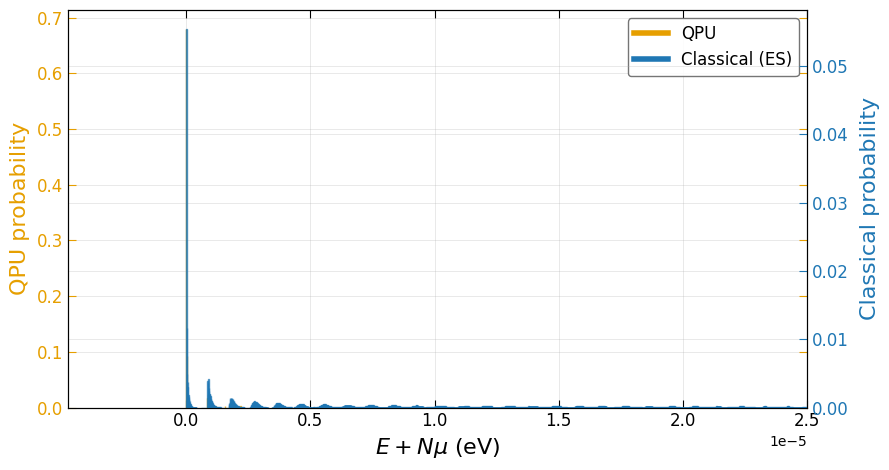

In [22]:
plot_classical_binned_vs_qpu_dual_axis_pretty(
    classical_csv="data/Monte_carlo/production/num_states_vs_energy__mu=0.csv",
    df_qpu=df_qpu,                 # from compute_qpu_state_energies_for_mu
    use_energy_with_mu=True,
    normalize=True,
    shift_fraction=0.25,
    xmax_fixed=2.5e-5,
    clip_qpu_ylim=False,    # keep this if you like
    clip_class_ylim=False, 
)

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# -----------------------------------------------------------
# Small helper to draw the diagonal "break" marks
# -----------------------------------------------------------
def draw_break(ax, where="top", size=0.015, line_kw=None):
    """
    Draw small diagonal break marks on an axis.
    where: "top" or "bottom"
    """
    if line_kw is None:
        line_kw = dict(color="k", linewidth=1.0, clip_on=False)

    # 0..1 in Axes coordinates
    x1, x2 = 0.02, 0.98
    y = 1 if where == "top" else 0

    dx = size
    dy = size

    # left diagonal
    ax.plot([x1 - dx, x1 + dx], [y - dy, y + dy],
            transform=ax.transAxes, **line_kw)
    # right diagonal
    ax.plot([x2 - dx, x2 + dx], [y - dy, y + dy],
            transform=ax.transAxes, **line_kw)


# -----------------------------------------------------------
# Main function: broken-axis QPU vs Classical energy plots
# -----------------------------------------------------------
def plot_qpu_classical_broken_axes(
    classical_csv,
    df_qpu,
    use_energy_with_mu=True,
    normalize=True,
    xmax_fixed=2.5e-5,
    qpu_split_frac=0.25,      # fraction of max used to split low/high panels
    cls_split_frac=0.25,      # same for classical
    mu_value=None,            # optional Δμ for annotation
):
    """
    Two-column figure:

      left  column: QPU histogram with broken y-axis
      right column: Classical (ES) histogram with broken y-axis

    Both use a common set of energy bins so the x-axis is directly comparable.
    """

    # ----------------------
    # 1) Load classical data
    # ----------------------
    df_class = pd.read_csv(classical_csv)
    left_edges_raw  = df_class["edge_left_eV"].to_numpy(dtype=float)
    right_edges_raw = df_class["edge_right_eV"].to_numpy(dtype=float)
    class_counts_raw = df_class["count"].to_numpy(dtype=float)

    class_bin_centers_raw = 0.5 * (left_edges_raw + right_edges_raw)

    # ----------------------
    # 2) Pick QPU energies
    # ----------------------
    if use_energy_with_mu:
        if "energy_plus_mu_eV" not in df_qpu.columns:
            raise KeyError("df_qpu must contain 'energy_plus_mu_eV' when use_energy_with_mu=True")
        qpu_energy = df_qpu["energy_plus_mu_eV"].to_numpy(dtype=float)
        x_label = r"$E + N\mu$ (eV)"
    else:
        if "energy_eV" not in df_qpu.columns:
            raise KeyError("df_qpu must contain 'energy_eV' when use_energy_with_mu=False")
        qpu_energy = df_qpu["energy_eV"].to_numpy(dtype=float)
        x_label = r"$E$ (eV)"

    # ----------------------
    # 3) Common binning
    # ----------------------
    n_class_bins = len(class_counts_raw)

    global_xmin = min(qpu_energy.min(), left_edges_raw.min())
    global_xmax = max(qpu_energy.max(), right_edges_raw.max())

    common_edges = np.linspace(global_xmin, global_xmax, n_class_bins + 1)
    common_centers = 0.5 * (common_edges[:-1] + common_edges[1:])
    common_widths  = (common_edges[1:] - common_edges[:-1])

    # Classical onto common bins (weighted)
    classical_hist_counts, _ = np.histogram(
        class_bin_centers_raw,
        bins=common_edges,
        weights=class_counts_raw
    )

    # QPU into same bins
    qpu_hist_counts, _ = np.histogram(qpu_energy, bins=common_edges)

    # ----------------------
    # 4) Normalize to PMFs
    # ----------------------
    if normalize:
        c_tot = classical_hist_counts.sum()
        q_tot = qpu_hist_counts.sum()

        classical_prob = (
            classical_hist_counts / c_tot if c_tot > 0
            else classical_hist_counts.astype(float)
        )
        qpu_prob = (
            qpu_hist_counts / q_tot if q_tot > 0
            else qpu_hist_counts.astype(float)
        )
    else:
        classical_prob = classical_hist_counts.astype(float)
        qpu_prob = qpu_hist_counts.astype(float)

    # ----------------------
    # 5) Choose y-limits for broken axes
    # ----------------------
    def compute_splits(prob, split_frac):
        ymax = prob.max() if len(prob) else 1.0
        if ymax == 0:
            return (0, 1), (0, 1)
        split = split_frac * ymax
        low_ylim  = (0, split * 1.05)
        high_ylim = (split * 0.98, ymax * 1.05)
        return low_ylim, high_ylim

    qpu_low_ylim, qpu_high_ylim = compute_splits(qpu_prob, qpu_split_frac)
    cls_low_ylim, cls_high_ylim = compute_splits(classical_prob, cls_split_frac)

    # ----------------------
    # 6) Figure & axes (2 rows x 2 columns)
    # ----------------------
    fig, axes = plt.subplots(
        2, 2,
        sharex='col',
        figsize=(11, 5.5),
        gridspec_kw={"height_ratios": [1, 2], "hspace": 0.05, "wspace": 0.25}
    )

    axQ_high, axC_high = axes[0]
    axQ_low,  axC_low  = axes[1]

    bar_width = common_widths * 0.8

    # ----------------------
    # 7) QPU panels (left)
    # ----------------------
    axQ_high.bar(common_centers, qpu_prob, width=bar_width,
                 color='#E69F00', edgecolor='#E69F00', alpha=0.8)
    axQ_low.bar(common_centers, qpu_prob, width=bar_width,
                color='#E69F00', edgecolor='#E69F00', alpha=0.8)

    axQ_high.set_ylim(*qpu_high_ylim)
    axQ_low.set_ylim(*qpu_low_ylim)

    axQ_low.set_ylabel("QPU probability", fontsize=14, color='#E69F00')
    axQ_low.tick_params(axis='y', colors='#E69F00')

    axQ_high.set_title("QPU", fontsize=15)

    # ----------------------
    # 8) Classical panels (right)
    # ----------------------
    axC_high.bar(common_centers, classical_prob, width=bar_width,
                 color='tab:blue', edgecolor='tab:blue', alpha=0.8)
    axC_low.bar(common_centers, classical_prob, width=bar_width,
                color='tab:blue', edgecolor='tab:blue', alpha=0.8)

    axC_high.set_ylim(*cls_high_ylim)
    axC_low.set_ylim(*cls_low_ylim)

    axC_low.set_ylabel("Classical probability", fontsize=14, color='tab:blue')
    axC_low.tick_params(axis='y', colors='tab:blue')

    axC_high.set_title("Classical (ES)", fontsize=15)

    # ----------------------
    # 9) Broken-axis decorations
    # ----------------------
    # hide inner spines
    for (ax_high, ax_low) in [(axQ_high, axQ_low), (axC_high, axC_low)]:
        ax_high.spines['bottom'].set_visible(False)
        ax_low.spines['top'].set_visible(False)

        # draw diagonal "breaks"
        draw_break(ax_high, where="bottom")
        draw_break(ax_low,  where="top")

    # ticks / grids / shared x label
    for ax in [axQ_high, axQ_low, axC_high, axC_low]:
        ax.tick_params(axis='both', which='both', direction='in', top=True, right=True,
                       labelsize=11, length=5)
        ax.grid(axis='y', linestyle=':', linewidth=0.5, alpha=0.4)

    axQ_low.set_xlabel(x_label, fontsize=16)
    axC_low.set_xlabel(x_label, fontsize=16)

    # X limits (shared per column)
    span = global_xmax - global_xmin
    pad = 0.05 * span
    xmin_plot = global_xmin - pad
    xmax_plot = xmax_fixed if xmax_fixed is not None else (global_xmax + pad)
    axQ_low.set_xlim(xmin_plot, xmax_plot)
    axC_low.set_xlim(xmin_plot, xmax_plot)

    # ----------------------
    # 10) Optional Δμ annotation (single textbox at top center)
    # ----------------------
    if mu_value is not None:
        mu = float(mu_value)
        mant, exp = f"{mu:.2e}".split("e")
        mant = float(mant)
        exp = int(exp)
        txt = rf"$\Delta\mu = {mant:.2f}\times10^{{{exp}}}\,\mathrm{{eV}}$"
        fig.text(
            0.5, 0.97, txt,
            ha='center', va='top',
            fontsize=13,
        )

    plt.tight_layout(rect=(0.02, 0.02, 0.98, 0.96))
    plt.show()

    # Debug (optional)
    print("QPU energy min/max:", qpu_energy.min(), qpu_energy.max())
    print("Classical edges min/max:", left_edges_raw.min(), right_edges_raw.max())
    print("Plotted xlim:", xmin_plot, xmax_plot)


# -----------------------------------------------------------
# Example call (adapt paths / df_qpu as needed)
# -----------------------------------------------------------
# classical_csv = "data/exhaustive_search/production/binned_energy_mu_-8.23e-8.csv"
# df_qpu = qpu_energy_df_for_that_mu   # DataFrame with energy_plus_mu_eV column
# plot_qpu_classical_broken_axes(classical_csv, df_qpu, mu_value=-8.23e-8)

/var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_50037/502943397.py:225: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=(0.02, 0.02, 0.98, 0.96))


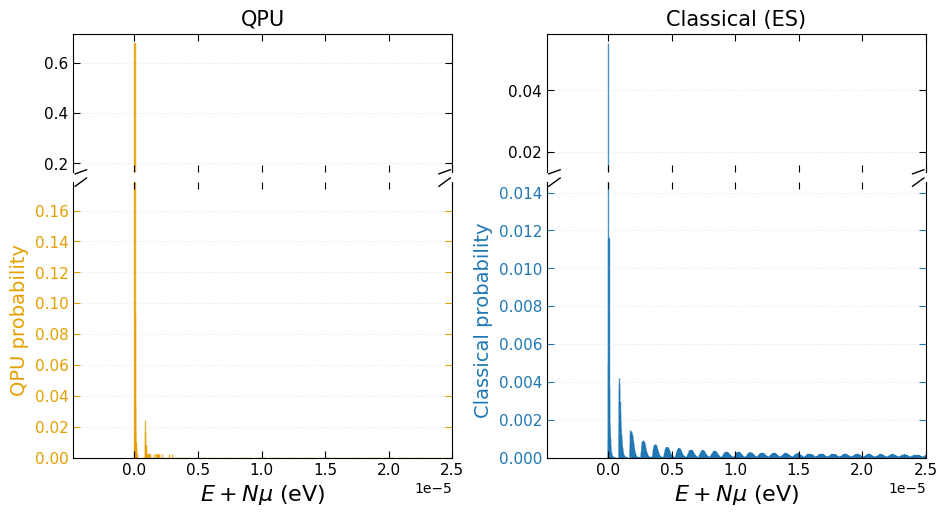

QPU energy min/max: 0.0 2.9689971373727046e-06
Classical edges min/max: 0.0 9.616e-05
Plotted xlim: -4.808e-06 2.5e-05


In [24]:
plot_qpu_classical_broken_axes(
    classical_csv="data/Monte_carlo/production/num_states_vs_energy__mu=0.csv",
    df_qpu=df_qpu, 
    use_energy_with_mu=True,
)

Max QPU probability (rebinned):      8.172e-01
Max Classical probability (rebinned): 7.287e-02


/var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_50037/3687145422.py:259: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


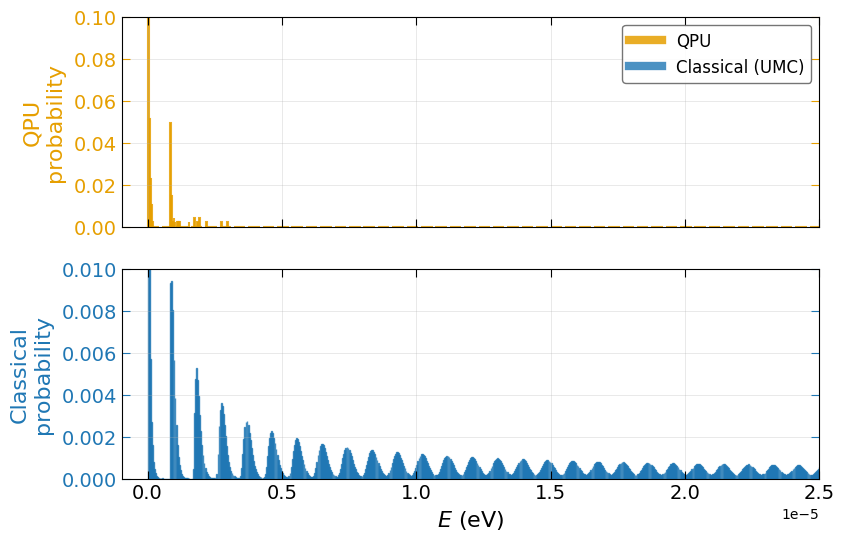

In [25]:
plot_qpu_vs_classical_stacked_bars(
    classical_csv="data/Monte_carlo/production/num_states_vs_energy__mu=0.csv",
    df_qpu=df_qpu,
    use_energy_with_mu=True,
    xmax_fixed=2.5e-5,
    rebin_factor=4,   # try 2, 4, 5 to taste
)

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_qpu_vs_classical_stacked_bars(
    classical_csv,
    df_qpu,
    use_energy_with_mu=True,
    normalize=True,
    xmax_fixed=2.5e-5,
    figsize=(9, 6),
    rebin_factor=4,   # merge this many original bins into one
):
    """
    Two vertically stacked bar plots (QPU on top, Classical on bottom),
    sharing the same energy axis and using a common binning.

    Parameters
    ----------
    classical_csv : str
        CSV file with columns: edge_left_eV, edge_right_eV, count
    df_qpu : pandas.DataFrame
        Must contain either 'energy_plus_mu_eV' or 'energy_eV'
    use_energy_with_mu : bool
        If True, use 'energy_plus_mu_eV' from df_qpu, else 'energy_eV'
    normalize : bool
        Normalize each dataset separately to a probability distribution.
    xmax_fixed : float or None
        Right x-limit. If None, use max energy + small padding.
    rebin_factor : int
        Number of neighbouring original bins to merge into one larger bin.
        Set to 1 to keep original resolution.
    """

    # -------------------------
    # 1. Load classical binned data
    # -------------------------
    df_class = pd.read_csv(classical_csv)
    left_edges_raw  = df_class["edge_left_eV"].to_numpy(float)
    right_edges_raw = df_class["edge_right_eV"].to_numpy(float)
    class_counts_raw = df_class["count"].to_numpy(float)

    # Original classical binning
    edges_raw   = np.concatenate([left_edges_raw[:1], right_edges_raw])
    centers_raw = 0.5 * (edges_raw[:-1] + edges_raw[1:])

    # -------------------------
    # 2. Pick QPU energy column
    # -------------------------
    if use_energy_with_mu:
        col = "energy_plus_mu_eV"
        if col not in df_qpu.columns:
            raise KeyError(f"df_qpu must contain '{col}' when use_energy_with_mu=True")
        qpu_energy = df_qpu[col].to_numpy(float)
        x_label = r"$E$ (eV)"
    else:
        col = "energy_eV"
        if col not in df_qpu.columns:
            raise KeyError(f"df_qpu must contain '{col}' when use_energy_with_mu=False")
        qpu_energy = df_qpu[col].to_numpy(float)
        x_label = r"$E$ (eV)"

    # -------------------------
    # 3. Common bin edges across BOTH datasets
    # -------------------------
    n_class_bins = len(class_counts_raw)

    global_xmin = float(min(qpu_energy.min(), left_edges_raw.min()))
    global_xmax = float(max(qpu_energy.max(), right_edges_raw.max()))

    common_edges = np.linspace(global_xmin, global_xmax, n_class_bins + 1)

    # -------------------------
    # 4. Histogram both on the common edges
    # -------------------------
    classical_hist, _ = np.histogram(
        centers_raw,
        bins=common_edges,
        weights=class_counts_raw,
    )
    qpu_hist, _ = np.histogram(qpu_energy, bins=common_edges)

    # -------------------------
    # 5. Normalize to probabilities (optionally)
    # -------------------------
    if normalize:
        cls_total = classical_hist.sum()
        qpu_total = qpu_hist.sum()

        classical_prob = (
            classical_hist / cls_total if cls_total > 0
            else classical_hist.astype(float)
        )
        qpu_prob = (
            qpu_hist / qpu_total if qpu_total > 0
            else qpu_hist.astype(float)
        )
    else:
        classical_prob = classical_hist.astype(float)
        qpu_prob = qpu_hist.astype(float)

    # -------------------------
    # 6. Optional rebinning to get "reasonable" bar widths
    # -------------------------
    def rebin_prob(edges, prob, m):
        """Merge m neighbouring bins: sum probs, compute new edges/centers."""
        if m <= 1:
            centers = 0.5 * (edges[:-1] + edges[1:])
            widths  = edges[1:] - edges[:-1]
            return edges, centers, widths, prob

        n_bins = len(edges) - 1
        n_groups = n_bins // m
        # truncate tail that doesn't fit into full groups
        n_use = n_groups * m
        edges_use = edges[:n_use + 1]
        prob_use  = prob[:n_use]

        # new edges: every m-th old edge
        new_edges = edges_use[::m]
        # make sure last edge is included
        if len(new_edges) != n_groups + 1:
            new_edges = np.append(new_edges, edges_use[-1])

        new_prob = prob_use.reshape(n_groups, m).sum(axis=1)
        new_centers = 0.5 * (new_edges[:-1] + new_edges[1:])
        new_widths  = new_edges[1:] - new_edges[:-1]

        return new_edges, new_centers, new_widths, new_prob

    edges_rb, centers_rb, widths_rb, qpu_prob_rb = rebin_prob(common_edges, qpu_prob, rebin_factor)
    _,        _,          _,         cls_prob_rb = rebin_prob(common_edges, classical_prob, rebin_factor)

    # ----- Print max probabilities -----
    max_qpu_prob = np.max(qpu_prob_rb) if len(qpu_prob_rb) else 0
    max_cls_prob = np.max(cls_prob_rb) if len(cls_prob_rb) else 0

    print(f"Max QPU probability (rebinned):      {max_qpu_prob:.3e}")
    print(f"Max Classical probability (rebinned): {max_cls_prob:.3e}")
    # -------------------------
    # 7. Set up stacked figure
    # -------------------------
    fig, (ax_qpu, ax_cls) = plt.subplots(
        2, 1,
        figsize=figsize,
        sharex=True,
        gridspec_kw={"height_ratios": [1, 1], "hspace": 0.2},
    )

    # -------------------------
    # 8. Top panel: QPU bars
    # -------------------------
    ax_qpu.bar(
        centers_rb,
        qpu_prob_rb,
        width=widths_rb * 0.8,
        align='center',
        color='#E69F00',
        edgecolor='#E69F00',
        alpha=0.85,
        linewidth=1.5,
    )

    ax_qpu.set_ylabel("QPU\nprobability", fontsize=16, color='#E69F00', labelpad=6)
    ax_qpu.tick_params(
        axis='y',
        colors='#E69F00',
        labelsize=14,
        direction='in',
        right=True,
        length=6,
    )
    ax_qpu.tick_params(
        axis='x',
        labelbottom=False,
        direction='in',
        top=True,
        bottom=True,
        length=6,
    )
    ax_qpu.grid(True, which='both', linewidth=0.5, alpha=0.4)

    # y-limit: clip the big spike but keep structure
    nz = qpu_prob_rb[qpu_prob_rb > 0]
    if len(nz) > 10:
        ymax_qpu = np.quantile(nz, 0.995) * 1.1
    else:
        ymax_qpu = qpu_prob_rb.max() * 1.05 if qpu_prob_rb.max() > 0 else 1.0
    ax_qpu.set_ylim(0, ymax_qpu)

    # -------------------------
    # 9. Bottom panel: Classical bars
    # -------------------------
    ax_cls.bar(
        centers_rb,
        cls_prob_rb,
        width=widths_rb * 0.8,
        align='center',
        color='tab:blue',
        edgecolor='tab:blue',
        alpha=0.8,
        linewidth=1.0,
    )

    ax_cls.set_ylabel("Classical\nprobability", fontsize=16, color='tab:blue', labelpad=6)
    ax_cls.tick_params(
        axis='y',
        colors='tab:blue',
        labelsize=14,
        direction='in',
        right=True,
        length=6,
    )
    ax_cls.tick_params(
        axis='x',
        labelsize=14,
        direction='in',
        top=True,
        bottom=True,
        length=6,
    )
    ax_cls.grid(True, which='both', linewidth=0.5, alpha=0.4)

    if cls_prob_rb.max() > 0:
        ax_cls.set_ylim(0, cls_prob_rb.max() * 1.05)
    ax_cls.set_ylim(0,0.01)
    # -------------------------
    # 10. Shared x-axis limits & label
    # -------------------------
    span = global_xmax - global_xmin
    pad = 0.01 * span
    xmin_plot = global_xmin - pad
    xmax_plot = xmax_fixed if xmax_fixed is not None else (global_xmax + pad)

    ax_cls.set_xlim(xmin_plot, xmax_plot)
    ax_qpu.set_ylim(0, 0.1)
    ax_cls.set_xlabel(x_label, fontsize=16)

    ax_cls.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

    # -------------------------
    # 11. Combined legend in top panel
    # -------------------------
    handles = [
        plt.Line2D([], [], color='#E69F00', lw=6, label='QPU', alpha=0.85),
        plt.Line2D([], [], color='tab:blue', lw=6, label='Classical (UMC)', alpha=0.8),
    ]
    ax_qpu.legend(
        handles=handles,
        loc='upper right',
        fontsize=12,
        frameon=True,
        facecolor='white',
        edgecolor='0.4',
        framealpha=0.9,
    )

    plt.tight_layout()
    plt.show()

Max QPU probability (rebinned):      8.172e-01
Max Classical probability (rebinned): 7.287e-02


/var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_50037/3687145422.py:259: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


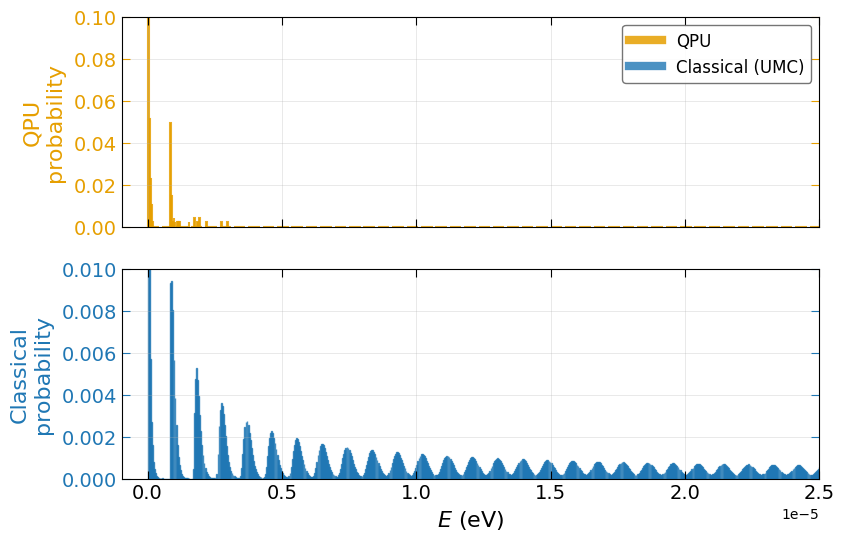

In [27]:
plot_qpu_vs_classical_stacked_bars(
    classical_csv="data/Monte_carlo/production/num_states_vs_energy__mu=0.csv",
    df_qpu=df_qpu,
    use_energy_with_mu=True,
    normalize=True,
    xmax_fixed=2.5e-5,
)

Wrote states_at_E0_by_conc.csv


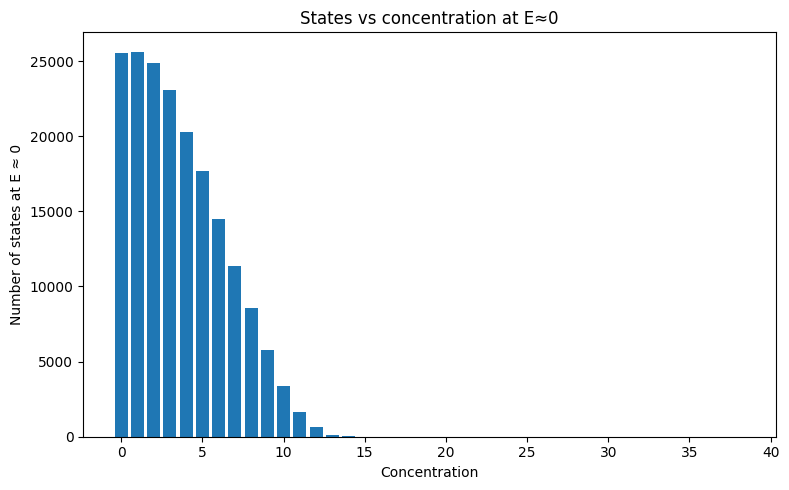

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your histogram (tidy format)
df = pd.read_csv("data/Monte_carlo/production/histogram.csv")

# Compute bin centers for convenience
df["bin_center"] = 0.5*(df["bin_left"] + df["bin_right"])

# 1) Try to select the bin that actually contains 0
mask_contains_zero = (df["bin_left"] <= 0) & (0 < df["bin_right"])

if mask_contains_zero.any():
    df0 = df[mask_contains_zero].copy()
else:
    # 2) Fallback: take the single bin whose center is closest to 0
    i = np.abs(df["bin_center"]).idxmin()
    bin_left, bin_right = df.loc[i, ["bin_left","bin_right"]]
    df0 = df[(df["bin_left"]==bin_left) & (df["bin_right"]==bin_right)].copy()
    print(f"[info] No bin strictly containing 0; using nearest-center bin "
          f"[{bin_left:.3g}, {bin_right:.3g}]")

# Sum counts by concentration for that bin
counts_by_conc = (df0.groupby("conc")["count"].sum()
                    .sort_index())  # conc ascending

# Optional: save a small CSV for export
out = counts_by_conc.reset_index()
out.columns = ["concentration","count_at_E≈0"]
out.to_csv("states_at_E0_by_conc.csv", index=False)
print("Wrote states_at_E0_by_conc.csv")

# Plot: bar chart
plt.figure(figsize=(8,5))
plt.bar(out["concentration"], out["count_at_E≈0"])
plt.xlabel("Concentration")
plt.ylabel("Number of states at E ≈ 0")
plt.title("States vs concentration at E≈0")
plt.tight_layout()
plt.show()

[info] df_classical head:
   concentration  classical_count_at_E≈0
0              0                   25507
1              1                   25630
2              2                   24866
3              3                   23072
4              4                   20275
[info] df_qpu columns: ['shot_index', 'conc', 'energy_eV', 'energy_plus_mu_eV', 'delta_g_rad_per_s', 'delta_mu_eV', 'bitstring']
[info] df_qpu_counts head:
   concentration  qpu_states_count
0              0                 1
1              1                 7
2              2                23
3              3                56
4              4                88


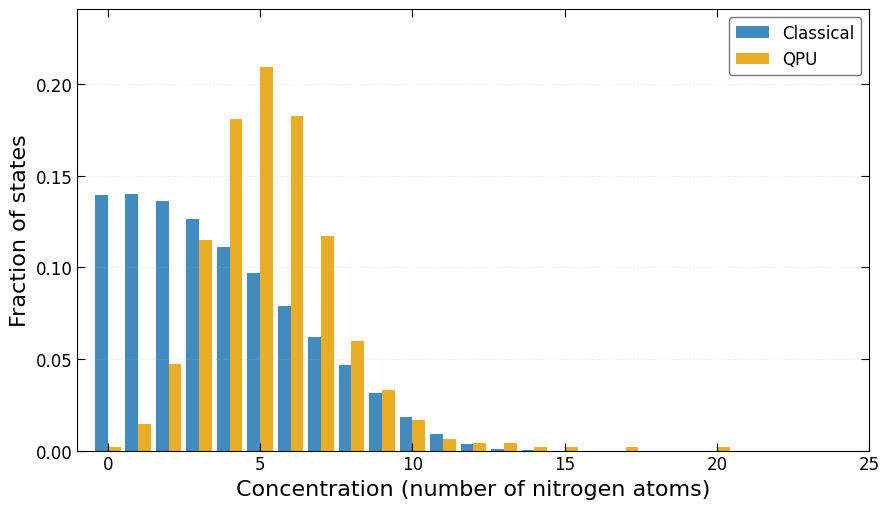

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------
# 1. Classical counts at E ≈ 0 from histogram.csv
# -------------------------------------------------
hist_path = "data/Monte_carlo/production/histogram.csv"   # adjust if needed
df_hist = pd.read_csv(hist_path)

# select the bin that straddles E ≈ 0
mask_zero_bin = (df_hist["bin_left"] <= 0.0) & (df_hist["bin_right"] >= 0.0)
df_zero = df_hist.loc[mask_zero_bin].copy()

# rename to canonical names
df_classical = df_zero.rename(
    columns={
        "conc":  "concentration",
        "count": "classical_count_at_E≈0",
    }
)[["concentration", "classical_count_at_E≈0"]]

df_classical["concentration"] = df_classical["concentration"].astype(int)

print("[info] df_classical head:")
print(df_classical.head())

# -------------------------------------------------
# 2. QPU counts *per nitrogen number* (use 'conc')
# -------------------------------------------------
print("[info] df_qpu columns:", list(df_qpu.columns))

# use the 'conc' column as number of nitrogen atoms
df_qpu_conc = df_qpu.copy()
df_qpu_conc["concentration"] = df_qpu_conc["conc"].astype(int)

# count how many QPU states we have for each concentration
df_qpu_counts = (
    df_qpu_conc
    .groupby("concentration")
    .size()
    .reset_index(name="qpu_states_count")
)

print("[info] df_qpu_counts head:")
print(df_qpu_counts.head())

# -------------------------------------------------
# 3. Merge and plot FRACTIONS
# -------------------------------------------------
df_merged = pd.merge(
    df_classical,
    df_qpu_counts,
    on="concentration",
    how="outer"
).fillna(0)

df_merged["concentration"] = df_merged["concentration"].astype(int)
df_merged = df_merged.sort_values("concentration")

x = df_merged["concentration"].to_numpy()
y_class_counts = df_merged["classical_count_at_E≈0"].to_numpy(dtype=float)
y_qpu_counts   = df_merged["qpu_states_count"].to_numpy(dtype=float)

# totals
total_classical = y_class_counts.sum()
total_qpu       = y_qpu_counts.sum()

class_frac = y_class_counts / total_classical if total_classical > 0 else np.zeros_like(y_class_counts)
qpu_frac   = y_qpu_counts   / total_qpu       if total_qpu       > 0 else np.zeros_like(y_qpu_counts)

# -------------------------------------------------
# 4. Plot
# -------------------------------------------------
width = 0.42
fig, ax = plt.subplots(figsize=(9, 5.2))

ax.bar(
    x - width/2, class_frac, width=width,
    color="tab:blue", alpha=0.85, label="Classical"
)
ax.bar(
    x + width/2, qpu_frac,   width=width,
    color="#E69F00", alpha=0.85, label="QPU"
)

ax.set_xlabel("Concentration (number of nitrogen atoms)", fontsize=16)
ax.set_ylabel("Fraction of states", fontsize=16)
ax.tick_params(axis='both', which='both',
               direction='in', top=True, right=True,
               labelsize=12, length=6)
ax.grid(True, axis='y', linestyle=':', alpha=0.35)

# focus on low concentrations (as in your original code)
if len(x) > 0:
    xmin = x.min() - 1
    xmax = x.max() + 1
    ax.set_xlim(xmin, 25)

ax.set_ylim(0, max(class_frac.max(), qpu_frac.max()) * 1.15
            if (class_frac.size and qpu_frac.size) else 1)

ax.legend(
    loc='best',
    fontsize=12,
    frameon=True,
    facecolor='white',
    edgecolor='0.4',
    framealpha=0.9,
)

plt.tight_layout()
plt.show()

### Analyse data from QA

In [32]:
preseqs, postseqs = read_all_sequences_from_folder('qpu_data/production/6x6/4micron/6')

preseqs = np.array(preseqs)
postseqs = np.array(postseqs)
num_atoms = preseqs.shape[1]
keep_config = np.where(np.sum(preseqs, axis=1) == num_atoms)[0]

postseqs = postseqs[keep_config]
postseqs = 1 - postseqs
# hamming_all_tmp = np.sum(postseqs[keep_config] == 0, axis=1)
# hamming_unique, hamming_count = np.unique(hamming_all_tmp, return_counts=True)

In [34]:
coordinates = np.array([[ 0.00000000e+00,  0.00000000e+00],
       [-2.00500000e-06,  3.47276187e-06],
       [ 0.00000000e+00,  6.94552374e-06],
       [-2.00500000e-06,  1.04182856e-05],
       [ 0.00000000e+00,  1.38910475e-05],
       [-2.00500000e-06,  1.73638093e-05],
       [ 0.00000000e+00,  2.08365712e-05],
       [-2.00500000e-06,  2.43093331e-05],
       [ 0.00000000e+00,  2.77820950e-05],
       [-2.00500000e-06,  3.12548568e-05],
       [ 0.00000000e+00,  3.47276187e-05],
       [-2.00500000e-06,  3.82003806e-05],
       [ 0.00000000e+00,  4.16731424e-05],
       [ 4.01000000e-06,  0.00000000e+00],
       [ 6.01500000e-06,  3.47276187e-06],
       [ 4.01000000e-06,  6.94552374e-06],
       [ 6.01500000e-06,  1.04182856e-05],
       [ 4.01000000e-06,  1.38910475e-05],
       [ 6.01500000e-06,  1.73638093e-05],
       [ 4.01000000e-06,  2.08365712e-05],
       [ 6.01500000e-06,  2.43093331e-05],
       [ 4.01000000e-06,  2.77820950e-05],
       [ 6.01500000e-06,  3.12548568e-05],
       [ 4.01000000e-06,  3.47276187e-05],
       [ 6.01500000e-06,  3.82003806e-05],
       [ 4.01000000e-06,  4.16731424e-05],
       [ 1.20300000e-05,  0.00000000e+00],
       [ 1.00250000e-05,  3.47276187e-06],
       [ 1.20300000e-05,  6.94552374e-06],
       [ 1.00250000e-05,  1.04182856e-05],
       [ 1.20300000e-05,  1.38910475e-05],
       [ 1.00250000e-05,  1.73638093e-05],
       [ 1.20300000e-05,  2.08365712e-05],
       [ 1.00250000e-05,  2.43093331e-05],
       [ 1.20300000e-05,  2.77820950e-05],
       [ 1.00250000e-05,  3.12548568e-05],
       [ 1.20300000e-05,  3.47276187e-05],
       [ 1.00250000e-05,  3.82003806e-05],
       [ 1.20300000e-05,  4.16731424e-05],
       [ 1.60400000e-05,  0.00000000e+00],
       [ 1.80450000e-05,  3.47276187e-06],
       [ 1.60400000e-05,  6.94552374e-06],
       [ 1.80450000e-05,  1.04182856e-05],
       [ 1.60400000e-05,  1.38910475e-05],
       [ 1.80450000e-05,  1.73638093e-05],
       [ 1.60400000e-05,  2.08365712e-05],
       [ 1.80450000e-05,  2.43093331e-05],
       [ 1.60400000e-05,  2.77820950e-05],
       [ 1.80450000e-05,  3.12548568e-05],
       [ 1.60400000e-05,  3.47276187e-05],
       [ 1.80450000e-05,  3.82003806e-05],
       [ 1.60400000e-05,  4.16731424e-05],
       [ 2.40600000e-05,  0.00000000e+00],
       [ 2.20550000e-05,  3.47276187e-06],
       [ 2.40600000e-05,  6.94552374e-06],
       [ 2.20550000e-05,  1.04182856e-05],
       [ 2.40600000e-05,  1.38910475e-05],
       [ 2.20550000e-05,  1.73638093e-05],
       [ 2.40600000e-05,  2.08365712e-05],
       [ 2.20550000e-05,  2.43093331e-05],
       [ 2.40600000e-05,  2.77820950e-05],
       [ 2.20550000e-05,  3.12548568e-05],
       [ 2.40600000e-05,  3.47276187e-05],
       [ 2.20550000e-05,  3.82003806e-05],
       [ 2.40600000e-05,  4.16731424e-05],
       [ 2.80700000e-05,  0.00000000e+00],
       [ 3.00750000e-05,  3.47276187e-06],
       [ 2.80700000e-05,  6.94552374e-06],
       [ 3.00750000e-05,  1.04182856e-05],
       [ 2.80700000e-05,  1.38910475e-05],
       [ 3.00750000e-05,  1.73638093e-05],
       [ 2.80700000e-05,  2.08365712e-05],
       [ 3.00750000e-05,  2.43093331e-05],
       [ 2.80700000e-05,  2.77820950e-05],
       [ 3.00750000e-05,  3.12548568e-05],
       [ 2.80700000e-05,  3.47276187e-05],
       [ 3.00750000e-05,  3.82003806e-05],
       [ 2.80700000e-05,  4.16731424e-05]])

dm = distance_matrix(coordinates, coordinates)

C6 = 5.42e-24  # C6 constant in rad m^6 / s
eV_to_rad_s = 1.519267447321156e15

np.fill_diagonal(dm,1)
dm_inv = 1/dm


dm_inv_6 = dm_inv**6

dm_inv_6_C6 = C6*dm_inv_6

dm_inv_6_C6_eV = dm_inv_6_C6/eV_to_rad_s

np.fill_diagonal(dm_inv_6_C6_eV,0)

In [35]:
coords = np.array([[ 0.        ,  0.        ],
       [-0.5       ,  0.8660254 ],
       [ 0.        ,  1.73205081],
       [-0.5       ,  2.59807621],
       [ 0.        ,  3.46410162],
       [-0.5       ,  4.33012702],
       [ 0.        ,  5.19615242],
       [-0.5       ,  6.06217783],
       [ 0.        ,  6.92820323],
       [-0.5       ,  7.79422863],
       [ 0.        ,  8.66025404],
       [-0.5       ,  9.52627944],
       [ 0.        , 10.39230485],
       [ 1.        ,  0.        ],
       [ 1.5       ,  0.8660254 ],
       [ 1.        ,  1.73205081],
       [ 1.5       ,  2.59807621],
       [ 1.        ,  3.46410162],
       [ 1.5       ,  4.33012702],
       [ 1.        ,  5.19615242],
       [ 1.5       ,  6.06217783],
       [ 1.        ,  6.92820323],
       [ 1.5       ,  7.79422863],
       [ 1.        ,  8.66025404],
       [ 1.5       ,  9.52627944],
       [ 1.        , 10.39230485],
       [ 3.        ,  0.        ],
       [ 2.5       ,  0.8660254 ],
       [ 3.        ,  1.73205081],
       [ 2.5       ,  2.59807621],
       [ 3.        ,  3.46410162],
       [ 2.5       ,  4.33012702],
       [ 3.        ,  5.19615242],
       [ 2.5       ,  6.06217783],
       [ 3.        ,  6.92820323],
       [ 2.5       ,  7.79422863],
       [ 3.        ,  8.66025404],
       [ 2.5       ,  9.52627944],
       [ 3.        , 10.39230485],
       [ 4.        ,  0.        ],
       [ 4.5       ,  0.8660254 ],
       [ 4.        ,  1.73205081],
       [ 4.5       ,  2.59807621],
       [ 4.        ,  3.46410162],
       [ 4.5       ,  4.33012702],
       [ 4.        ,  5.19615242],
       [ 4.5       ,  6.06217783],
       [ 4.        ,  6.92820323],
       [ 4.5       ,  7.79422863],
       [ 4.        ,  8.66025404],
       [ 4.5       ,  9.52627944],
       [ 4.        , 10.39230485],
       [ 6.        ,  0.        ],
       [ 5.5       ,  0.8660254 ],
       [ 6.        ,  1.73205081],
       [ 5.5       ,  2.59807621],
       [ 6.        ,  3.46410162],
       [ 5.5       ,  4.33012702],
       [ 6.        ,  5.19615242],
       [ 5.5       ,  6.06217783],
       [ 6.        ,  6.92820323],
       [ 5.5       ,  7.79422863],
       [ 6.        ,  8.66025404],
       [ 5.5       ,  9.52627944],
       [ 6.        , 10.39230485],
       [ 7.        ,  0.        ],
       [ 7.5       ,  0.8660254 ],
       [ 7.        ,  1.73205081],
       [ 7.5       ,  2.59807621],
       [ 7.        ,  3.46410162],
       [ 7.5       ,  4.33012702],
       [ 7.        ,  5.19615242],
       [ 7.5       ,  6.06217783],
       [ 7.        ,  6.92820323],
       [ 7.5       ,  7.79422863],
       [ 7.        ,  8.66025404],
       [ 7.5       ,  9.52627944],
       [ 7.        , 10.39230485]])

coords = coords*1.4247412

dm = distance_matrix(coords, coords)
np.fill_diagonal(dm,0)
dm = np.triu(dm)


In [36]:
coords[np.where(postseqs[1]==1)[0]]

array([[-0.7123706 ,  3.70158622],
       [ 0.        ,  7.40317243],
       [ 0.        , 14.80634488],
       [ 3.561853  ,  3.70158622],
       [ 5.6989648 , 12.33862073],
       [ 9.9731884 ,  4.9354483 ],
       [10.685559  , 11.10475865],
       [10.685559  , 13.5724828 ]])

In [37]:
from scipy.spatial.distance import pdist, squareform
all_energy = []
all_conc = []
for x in postseqs:
    all_conc.append(np.sum(x))
    xx = np.outer(x,x)
    dm_xx = dm_inv_6_C6_eV * xx
    energy = np.sum(np.triu(dm_xx))
    if np.sum(x)>1:
        print(np.sum(x),pdist(coords[np.where(x==1)[0]]).mean(),pdist(coords[np.where(x==1)[0]]).min(),energy)
    all_energy.append(float(f"{energy:.12g}"))

5 9.557398425884394 4.274223610668815 1.576635967423605e-09
8 8.977272761035804 2.4677241495003717 3.7150597783391676e-08
5 10.323830553387724 5.136977459743086 5.636080308835889e-10
4 9.6633200978784 5.136977452993133 5.649928487660677e-10
9 8.32549580088591 2.4677241433407278 9.932242994722747e-08
5 8.341186727164297 2.467724143340728 3.2330746378679564e-08
7 8.663002230037918 3.7695108959343555 5.981527938078241e-09
4 10.421401184373053 4.274223598330194 1.2109489786246954e-09
7 10.27219644696831 3.7695108959343555 7.819418711502289e-09
4 9.049107361840518 4.274223598330194 1.4254804217253905e-09
2 4.935448284753331 4.935448284753331 4.965409557101577e-10
5 10.2501444468848 4.2742236 2.4516097435271842e-09
8 7.5328534127621225 2.4677241352529595 4.606358598079551e-08
11 8.480829374525092 1.4247411953305245 1.8531680654895738e-06
5 10.54870116391504 6.210302913024331 2.873847709170663e-10
6 8.607787497212145 2.4677241495003717 6.665356396541023e-08
4 7.661351552019344 4.9354482938051

In [38]:
df

,bin_left,bin_right,conc,count,bin_center
0,-1.000000e-12,1.659431e-07,0,25507,8.297106e-08
1,-1.000000e-12,1.659431e-07,1,25630,8.297106e-08
2,-1.000000e-12,1.659431e-07,2,24866,8.297106e-08
3,-1.000000e-12,1.659431e-07,3,23072,8.297106e-08
4,-1.000000e-12,1.659431e-07,4,20275,8.297106e-08
...,...,...,...,...,...
7795,3.302288e-05,3.318882e-05,34,0,3.310585e-05
7796,3.302288e-05,3.318882e-05,35,0,3.310585e-05
7797,3.302288e-05,3.318882e-05,36,0,3.310585e-05
7798,3.302288e-05,3.318882e-05,37,0,3.310585e-05


/var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_50037/2790129229.py:21: RuntimeWarning: invalid value encountered in divide
  mean_dist = sum_dist / (k * (k - 1) / 2)


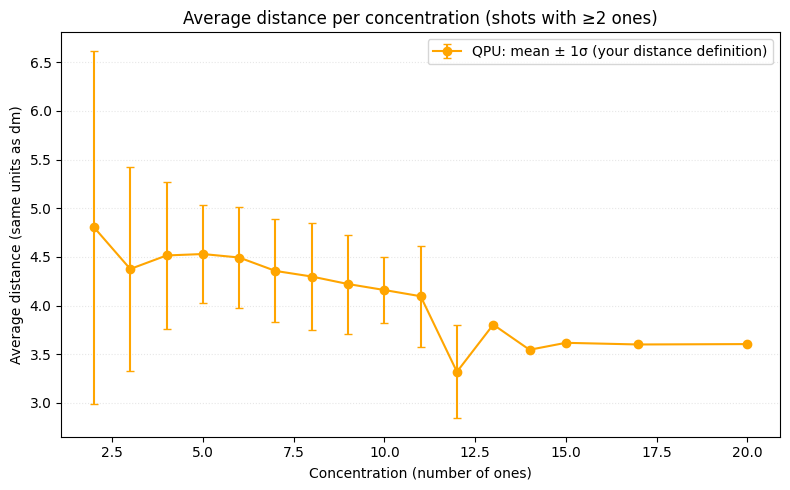

,concentration,mean,std,count
0,2,4.804535,1.814865,23
1,3,4.375429,1.050872,56
2,4,4.514551,0.759811,88
3,5,4.529356,0.502074,102
4,6,4.493485,0.521227,89


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assumes you already have:
#   postseqs : (shots, N) array of 0/1
#   dm       : (N, N) symmetric distance matrix (same units you want to report)
# If dm’s diagonal isn’t exactly zero, we zero it for safety:
dm = np.asarray(dm, dtype=float).copy()
np.fill_diagonal(dm, 0.0)

# --- Compute per-shot distances_mean using your formula, exclude k<2 ---
X = np.asarray(postseqs, dtype=float)            # (B, N), 1 = "present"
k = X.sum(axis=1)                                # concentration per shot (number of ones)

# Vectorized version of: distances = sum(triu(dm * outer(x,x)))
# Correct average distance between occupied sites
totals = (X @ dm) * X
sum_dist = 0.5 * totals.sum(axis=1)      # sum_{i<j} d_ij x_i x_j
k = X.sum(axis=1)
mean_dist = sum_dist / (k * (k - 1) / 2)

# Keep only shots with at least 2 ones
mask = k >= 2
k_valid = k[mask].astype(int)
dmean_valid = mean_dist[mask]

# --- Aggregate: mean ± std per concentration ---
df = pd.DataFrame({"concentration": k_valid, "distances_mean": dmean_valid})
agg = df.groupby("concentration")["distances_mean"].agg(
    mean="mean", std=lambda s: s.std(ddof=1) if len(s) > 1 else 0.0, count="size"
).reset_index()

# --- Plot ---
plt.figure(figsize=(8,5))
plt.errorbar(
    agg["concentration"], agg["mean"],
    yerr=agg["std"], fmt="o-", capsize=3, color="orange",
    label="QPU: mean ± 1σ (your distance definition)"
)
plt.xlabel("Concentration (number of ones)")
plt.ylabel("Average distance (same units as dm)")
plt.title("Average distance per concentration (shots with ≥2 ones)")
plt.grid(axis="y", linestyle=":", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# If you want the table too:
agg.head()

<BarContainer object of 76 artists>

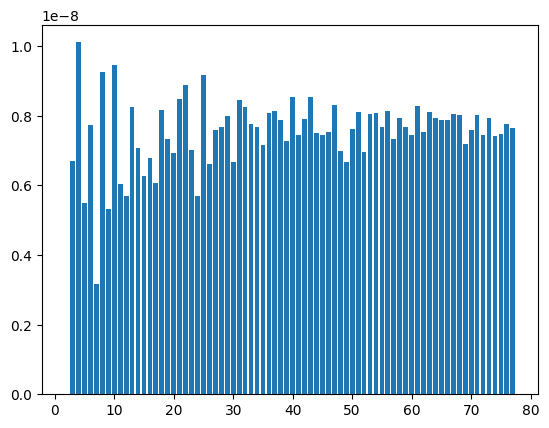

In [40]:
classical_csv = "data/Monte_carlo/production/avg_mean_distance_vs_conc.csv"
classical_csv_np = np.genfromtxt(classical_csv,delimiter=',')[3:]
plt.bar(classical_csv_np[:,0],classical_csv_np[:,1]-classical_csv_np[:,1].min())
